# 0.0. Imports

In [55]:
import pandas as pd
import numpy as np
import math
import random
import inflection
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import datetime as dt
import datetime
import pickle
import os
import warnings

from tabulate import tabulate
from scipy import stats  as ss

from IPython.core.display import HTML
from IPython.display import Image

from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
from xgboost import XGBRegressor

warnings.filterwarnings( 'ignore' )

## 0.1. Helper Functions

In [5]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )


def cross_validation(x, y, k_fold, model_name, model):
    # Assume 'X' is your feature matrix and 'y' is the target variable

    # Choose the number of folds (k)
    k_folds = k_fold

    # Initialize the model (replace with your model)
    model = model

    # Create a k-fold cross-validation object
    kf = KFold(n_splits=k_folds, shuffle=True)

    # Perform cross-validation and get performance scores
    mae = -cross_val_score(model, x, y, cv=kf, scoring='neg_mean_absolute_error').mean()
    mape = -cross_val_score(model, x, y, cv=kf, scoring='neg_mean_absolute_percentage_error').mean()
    rmse = -cross_val_score(model, x, y, cv=kf, scoring='neg_root_mean_squared_error').mean()

    return pd.DataFrame({ 'Model Name' : model_name,
                          'MAE' : mae,
                          'MAPE' : mape,
                          'RMSE' : rmse}, index=[0])


## 0.2. Loading Data

In [6]:
patch = os.getcwd()
df_sales_raw = pd.read_csv(patch + '/data/train.csv', low_memory=False)
df_store_raw = pd.read_csv(patch + '/data/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [7]:
# Verifying de dataframe
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# 1.0. Data Description

Data fields

- Id - an Id that represents a (Store, Date) duple within the test set


- Store - a unique Id for each store


- Sales - the turnover for any given day (this is what you are predicting)


- Customers - the number of customers on a given day


- Open - an indicator for whether the store was open: 0 = closed, 1 = open


- StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None


- SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools


- StoreType - differentiates between 4 different store models: a, b, c, d


- Assortment - describes an assortment level: a = basic, b = extra, c = extended


- CompetitionDistance - distance in meters to the nearest competitor store


- CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened


- Promo - indicates whether a store is running a promo on that day


- Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating


- Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2


- PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

Source: https://www.kaggle.com/c/rossmann-store-sales/data

In [8]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [9]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [10]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType',
            'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']
snake_case = lambda x: inflection.underscore(x)
cols_new = list(map(snake_case, cols_old))
df1.columns = cols_new

In [11]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2. Data Dimensions

In [12]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Columns: 18


## 1.3. Data Types

In [13]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [14]:
df1.date = pd.to_datetime(df1.date)
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [15]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [16]:
# checking 'competition_distance' column
df1['competition_distance'].max()

75860.0

In [17]:
# competition_distance

df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if pd.isna(x) else x)

# competition_open_since_month    
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if pd.isna(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)

# competition_open_since_year     
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if pd.isna(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)

# promo2_since_week               
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if pd.isna(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)

# promo2_since_year               
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if pd.isna(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)

# promo_interval                  
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)


In [23]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types

In [24]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [20]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

## 1.7. Descriptive Statistical

In [21]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

In [22]:
cat_attributes.sample(2)

,state_holiday,store_type,assortment,promo_interval,month_map
435561,0,c,c,0,Jun
814589,0,a,c,"Mar,Jun,Sept,Dec",Jul


### 1.7.1 Numerical Attributes

In [25]:
describe = num_attributes.describe().T
kurtosis = num_attributes.kurtosis().T
skew = num_attributes.skew().T
m = pd.concat([describe, skew, kurtosis], axis=1)
m.columns = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'skew', 'kurtosis']

In [26]:
m

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
store,1017209.0,558.429727,321.908651,1.0,280.0,558.0,838.0,1115.0,-0.000955,-1.200524
day_of_week,1017209.0,3.998341,1.997391,1.0,2.0,4.0,6.0,7.0,0.001593,-1.246873
sales,1017209.0,5773.818972,3849.926175,0.0,3727.0,5744.0,7856.0,41551.0,0.641460,1.778375
customers,1017209.0,633.145946,464.411734,0.0,405.0,609.0,837.0,7388.0,1.598650,7.091773
open,1017209.0,0.830107,0.375539,0.0,1.0,1.0,1.0,1.0,-1.758045,1.090723
promo,1017209.0,0.381515,0.485759,0.0,0.0,0.0,1.0,1.0,0.487838,-1.762018
school_holiday,1017209.0,0.178647,0.383056,0.0,0.0,0.0,0.0,1.0,1.677842,0.815154
competition_distance,1017209.0,5935.442677,12547.652996,20.0,710.0,2330.0,6910.0,200000.0,10.242344,147.789712
competition_open_since_month,1017209.0,6.786849,3.311087,1.0,4.0,7.0,10.0,12.0,-0.042076,-1.232607
competition_open_since_year,1017209.0,2010.324840,5.515593,1900.0,2008.0,2012.0,2014.0,2015.0,-7.235657,124.071304


<Axes: xlabel='sales', ylabel='Density'>

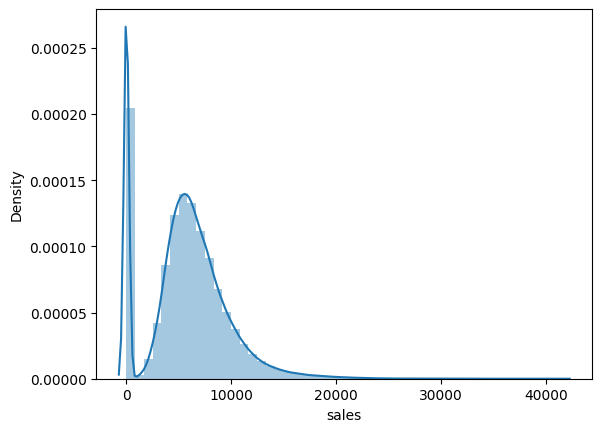

In [27]:
sns.distplot(df1['sales'])

### 1.7.2 Categorical Attributes

In [28]:
cat_attributes.apply(lambda x: x.nunique())

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

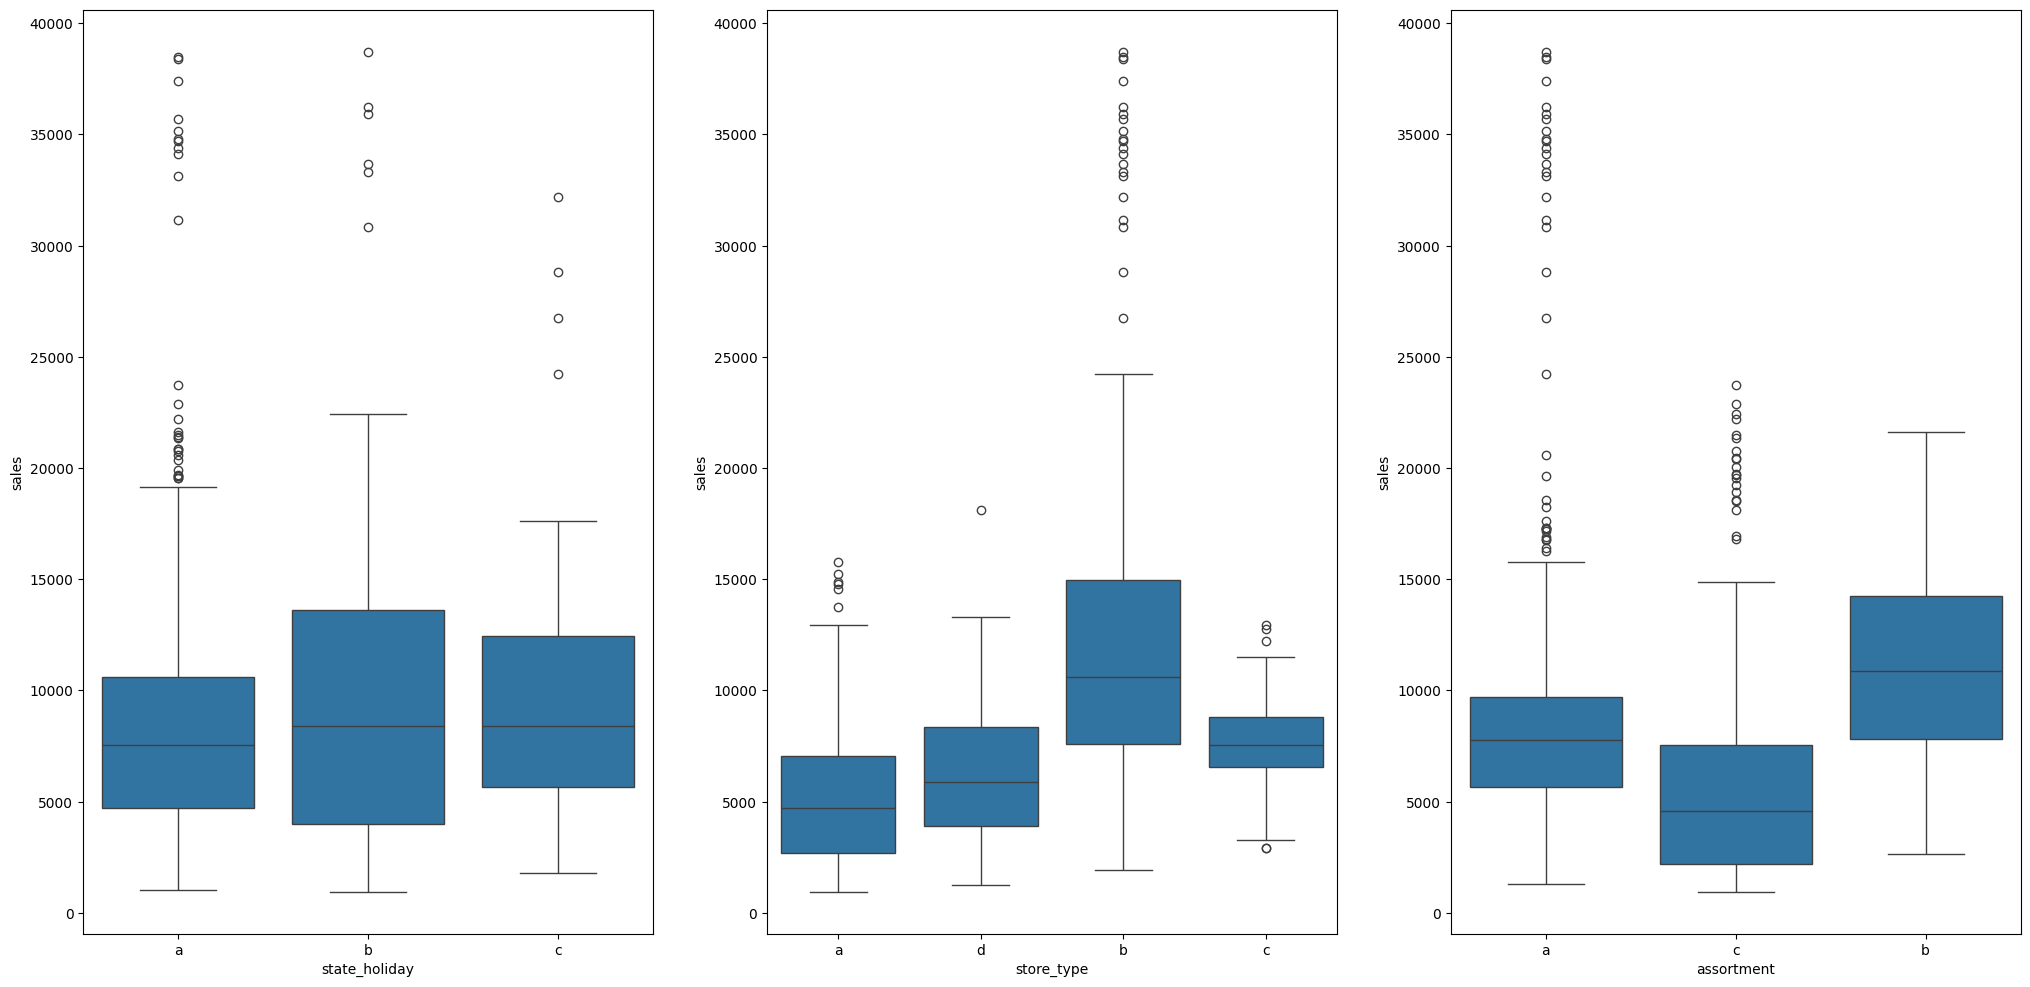

In [29]:
plt.rcParams['figure.figsize'] = [25, 12]
# plt.rcParams['font.size'] = 24

aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux1)

# 2.0. Featuring Engineering

In [30]:
df2 = df1.copy()

## 2.1. Hypothesis Mind Map

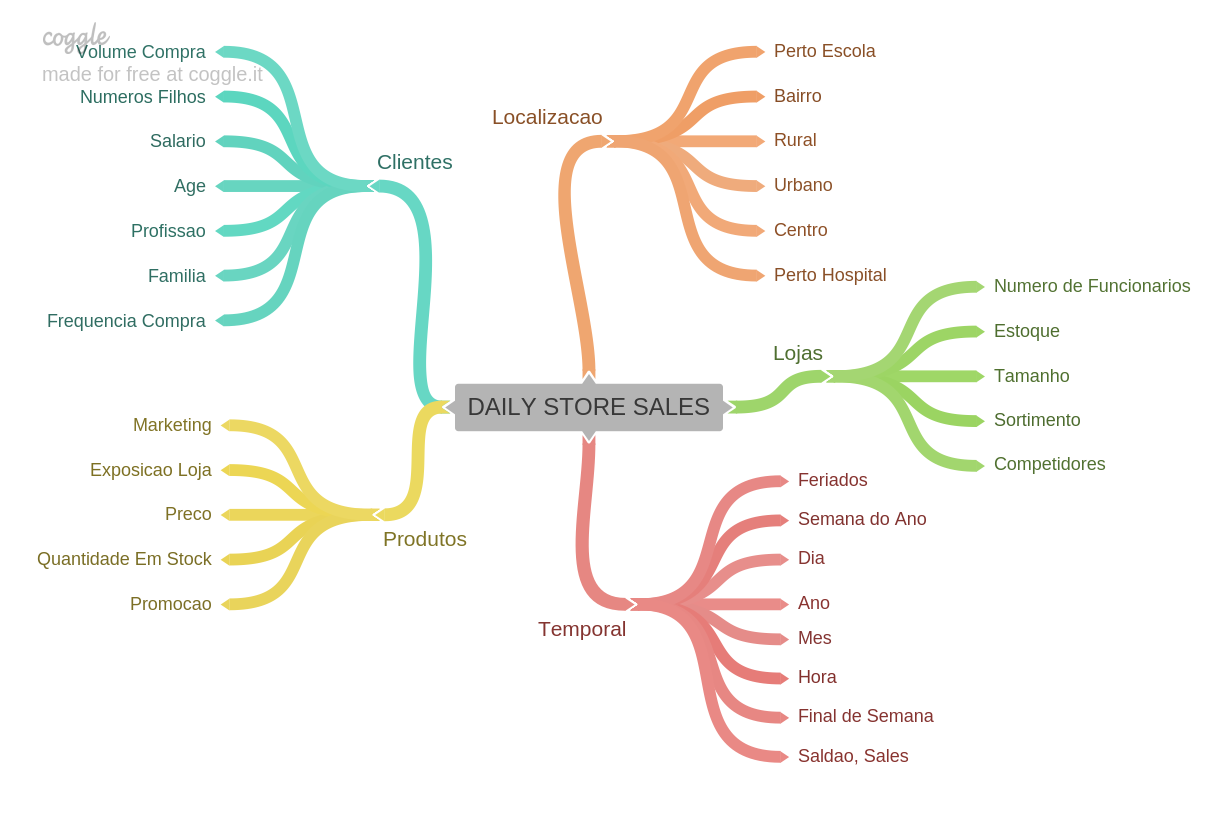

In [31]:
Image( 'img/MindMapHypothesis.png' )

## 2.2. Hypothesis creation

### 2.2.1. Stores Hypothesis

**1.** Stores with more employees should sell more.

**2.** Stores with more stock capacity should sell more.

**3.** Bigger stores should sell more.

**4.** Stores with greater assortments should sell more.

**5.** Stores with nearer competitors should sell less.

**6.** Stores with competitors for longer time should sell more.

### 2.2.2. Products Hypothesis

**1.** Stores that have more market investment should sell more.

**2.** Stores with greater product exposure should sell more

**3.** Stores with lower-priced products should sell more.

**5.** Stores with more aggressive promotions (bigger discounts) should sell more.

**6.** Stores with promotions active for longer periods should sell more.

**7.** Stores with more days of promotion should sell more.

**8.** Stores with more consecutive promotions should sell more.

### 2.2.3. Time Hypothesis

**1.** Stores open during the Christmas holiday should sell more.

**2.** Stores should sell more over the years.

**3.** Stores should sell more in the second half of the year.

**4.** Stores should sell more after the 10th of each month.

**5.** Stores should sell less on weekends.

**6.** Stores should sell less during school holidays.

## 2.3. Final List

**1.** Stores with greater assortments should sell more.

**2.** Stores with nearer competitors should sell less.

**3.** Stores with competitors for longer time should sell more.

**4.** Stores with promotions active for longer periods should sell more.

**5.** Stores with more consecutive promotions should sell more.

**6.** Stores open during the Christmas holiday should sell more.

**7.** Stores should sell more over the years.

**8.** Stores should sell more in the second half of the year.

**9.** Stores should sell more after the 10th of each month.

**10.** Stores should sell less on weekends.

**11.** Stores should sell less during school holidays.


## 2.4. Featuring Engineering

In [32]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of the year
# df2['week_of_year'] = df2['date'].dt.weekofyear
df2['week_of_year'] = df2['date'].dt.isocalendar().week


# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: dt.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply( lambda x: dt.datetime.strptime( x + '-1', '%Y-%W-%w' ) - dt.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

In [33]:
df2.T

,0,1,2,3,4,5,6,7,8,9,...,1017199,1017200,1017201,1017202,1017203,1017204,1017205,1017206,1017207,1017208
store,1,2,3,4,5,6,7,8,9,10,...,1106,1107,1108,1109,1110,1111,1112,1113,1114,1115
day_of_week,5,5,5,5,5,5,5,5,5,5,...,2,2,2,2,2,2,2,2,2,2
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,...,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00
sales,5263,6064,8314,13995,4822,5651,15344,8492,8565,7185,...,0,0,0,0,0,0,0,0,0,0
customers,555,625,821,1498,559,589,1414,833,687,681,...,0,0,0,0,0,0,0,0,0,0
open,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
promo,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,...,public_holiday,public_holiday,public_holiday,public_holiday,public_holiday,public_holiday,public_holiday,public_holiday,public_holiday,public_holiday
school_holiday,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
store_type,c,a,a,c,a,a,a,a,a,a,...,a,a,a,c,c,a,c,a,a,d


# 3.0. Variables Filtering

In [34]:
df3 = df2.copy()

## 3.1. Lines Filtering

In [35]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Columns Filtering

In [36]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [37]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. Exploratory Data Analysis (EDA)

In [38]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Response Variable

<Axes: xlabel='sales', ylabel='Count'>

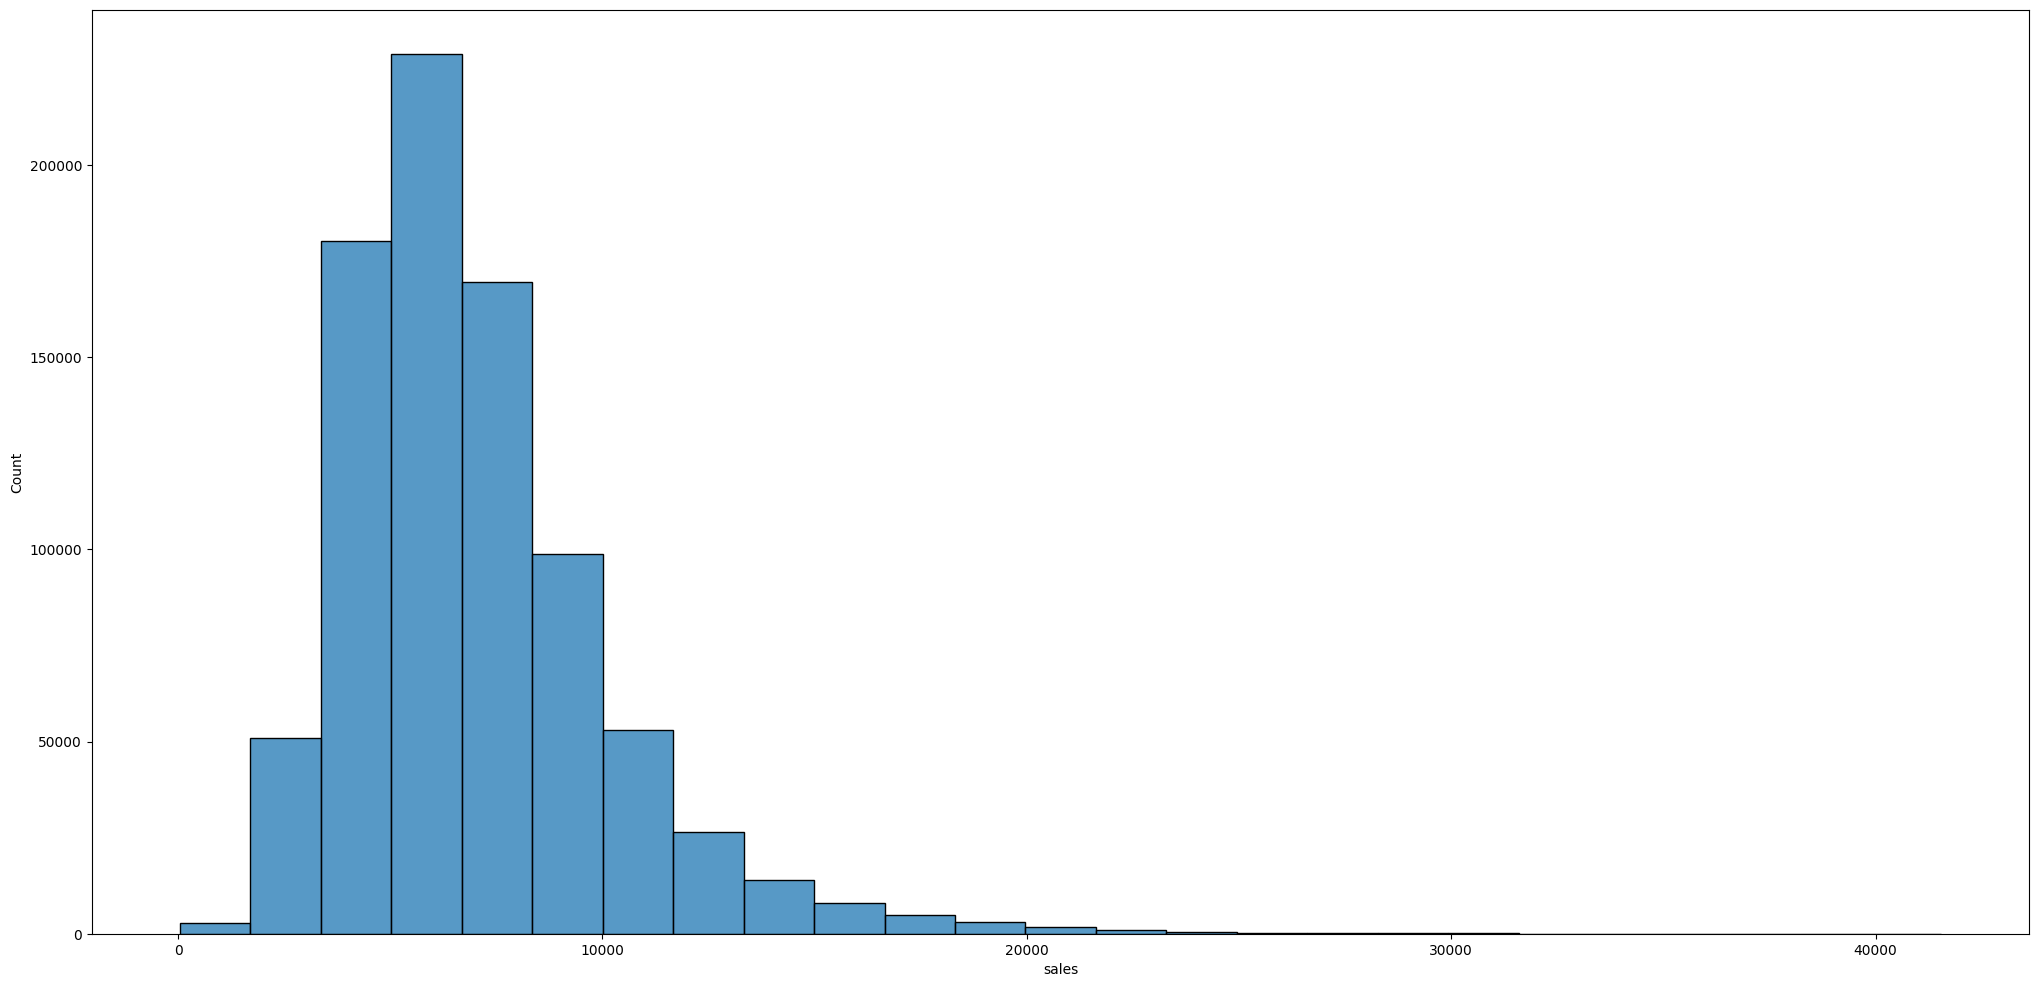

In [39]:
sns.histplot(df4['sales'], bins=25)

### 4.1.2. Numerical Variables

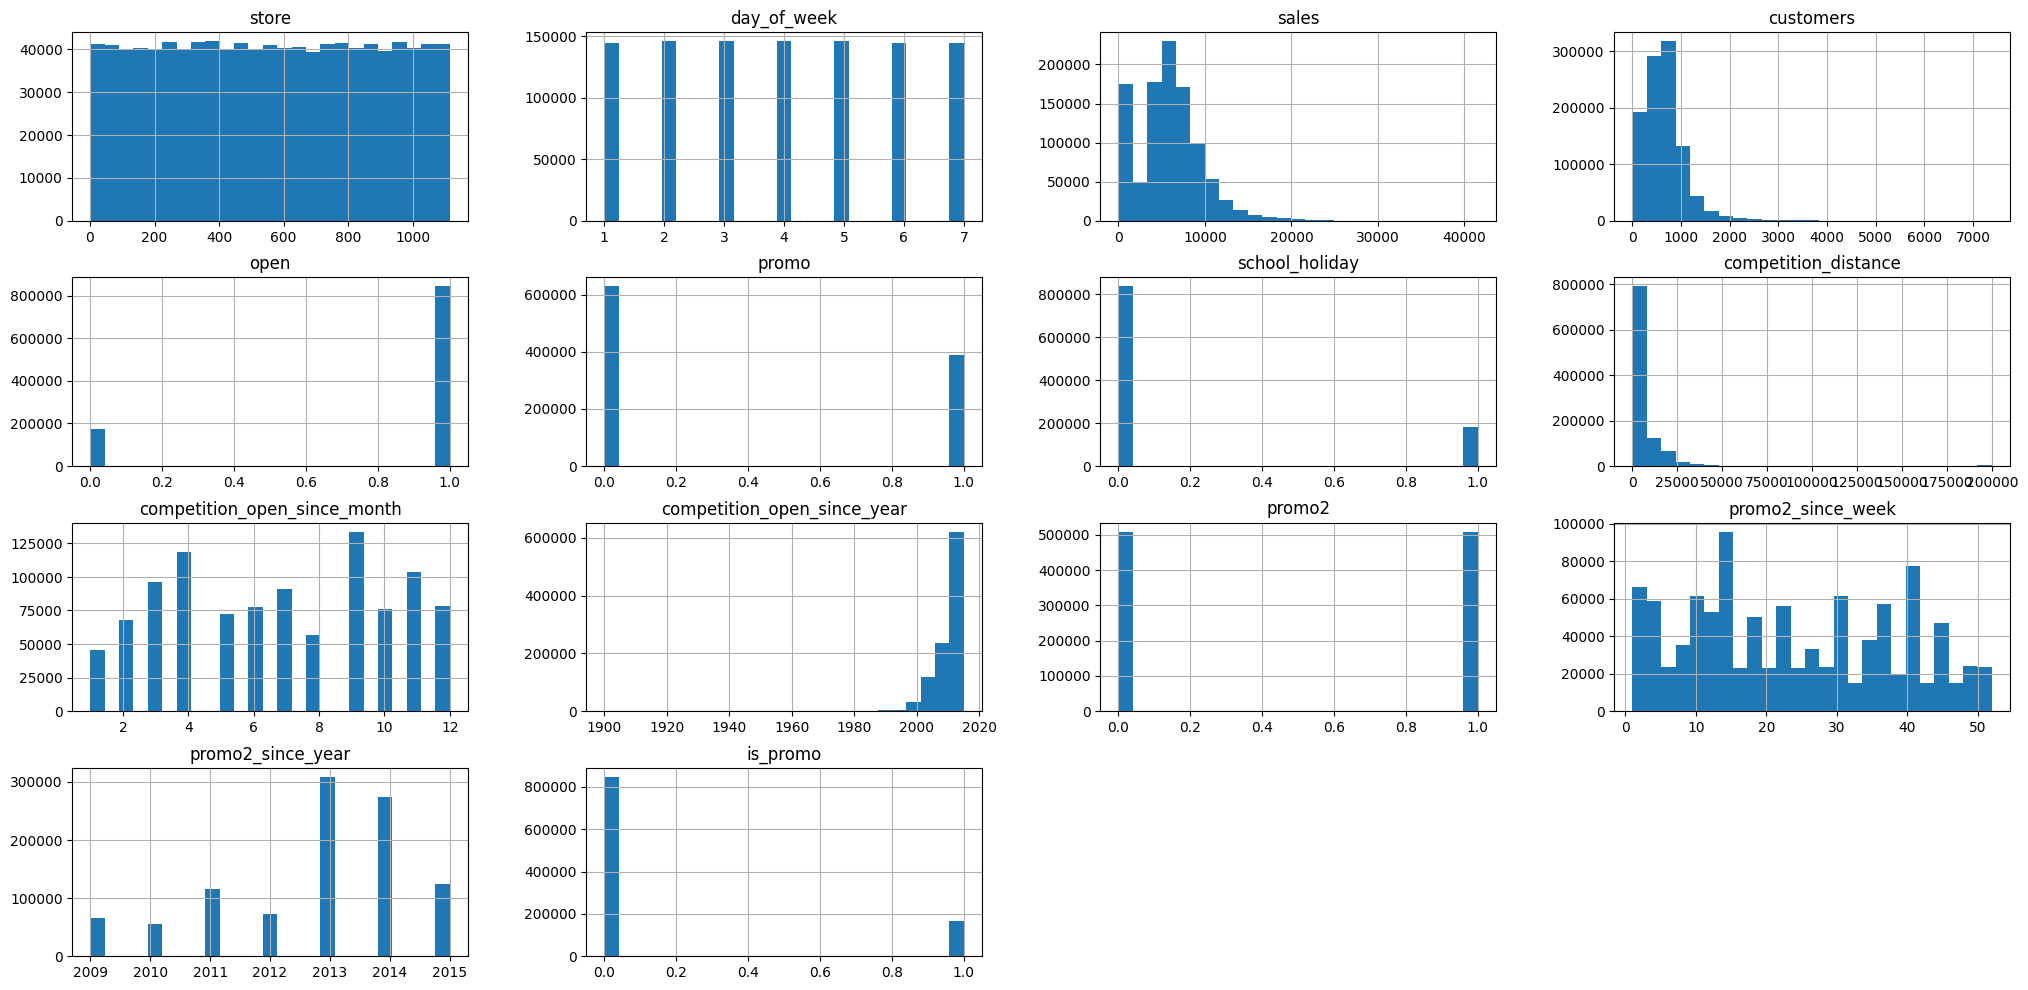

In [40]:
num_attributes.hist(bins=25);

In [41]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

<Axes: xlabel='sales', ylabel='Density'>

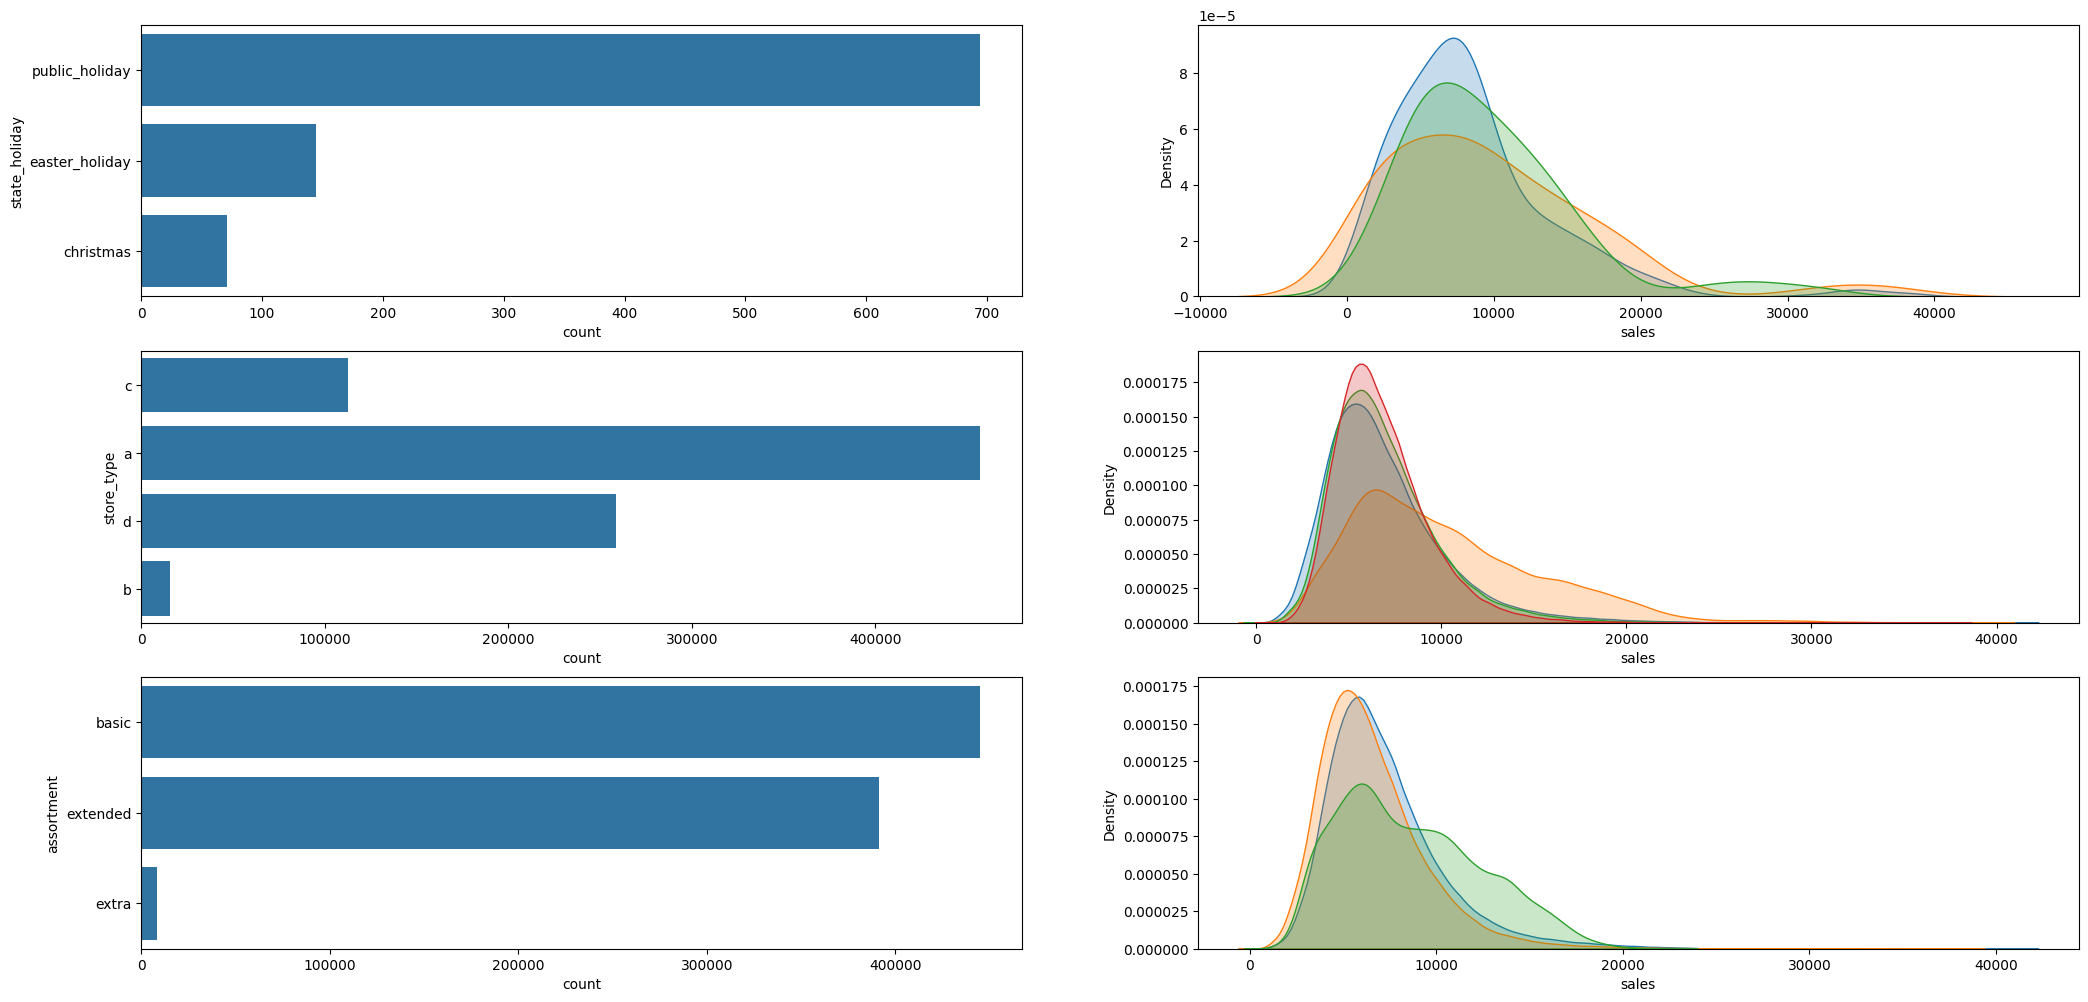

In [43]:
# state_holiday
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != ('regular_day')]['state_holiday']
sns.countplot(a)

plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True )

# store_type
plt.subplot( 3, 2, 3 )
sns.countplot( df4['store_type'] )

plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )

# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( df4['assortment'] )

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True )

## 4.2. Bivariate Analysis

### H1. Stores with greater assortments should sell more

<Axes: xlabel='year_week'>

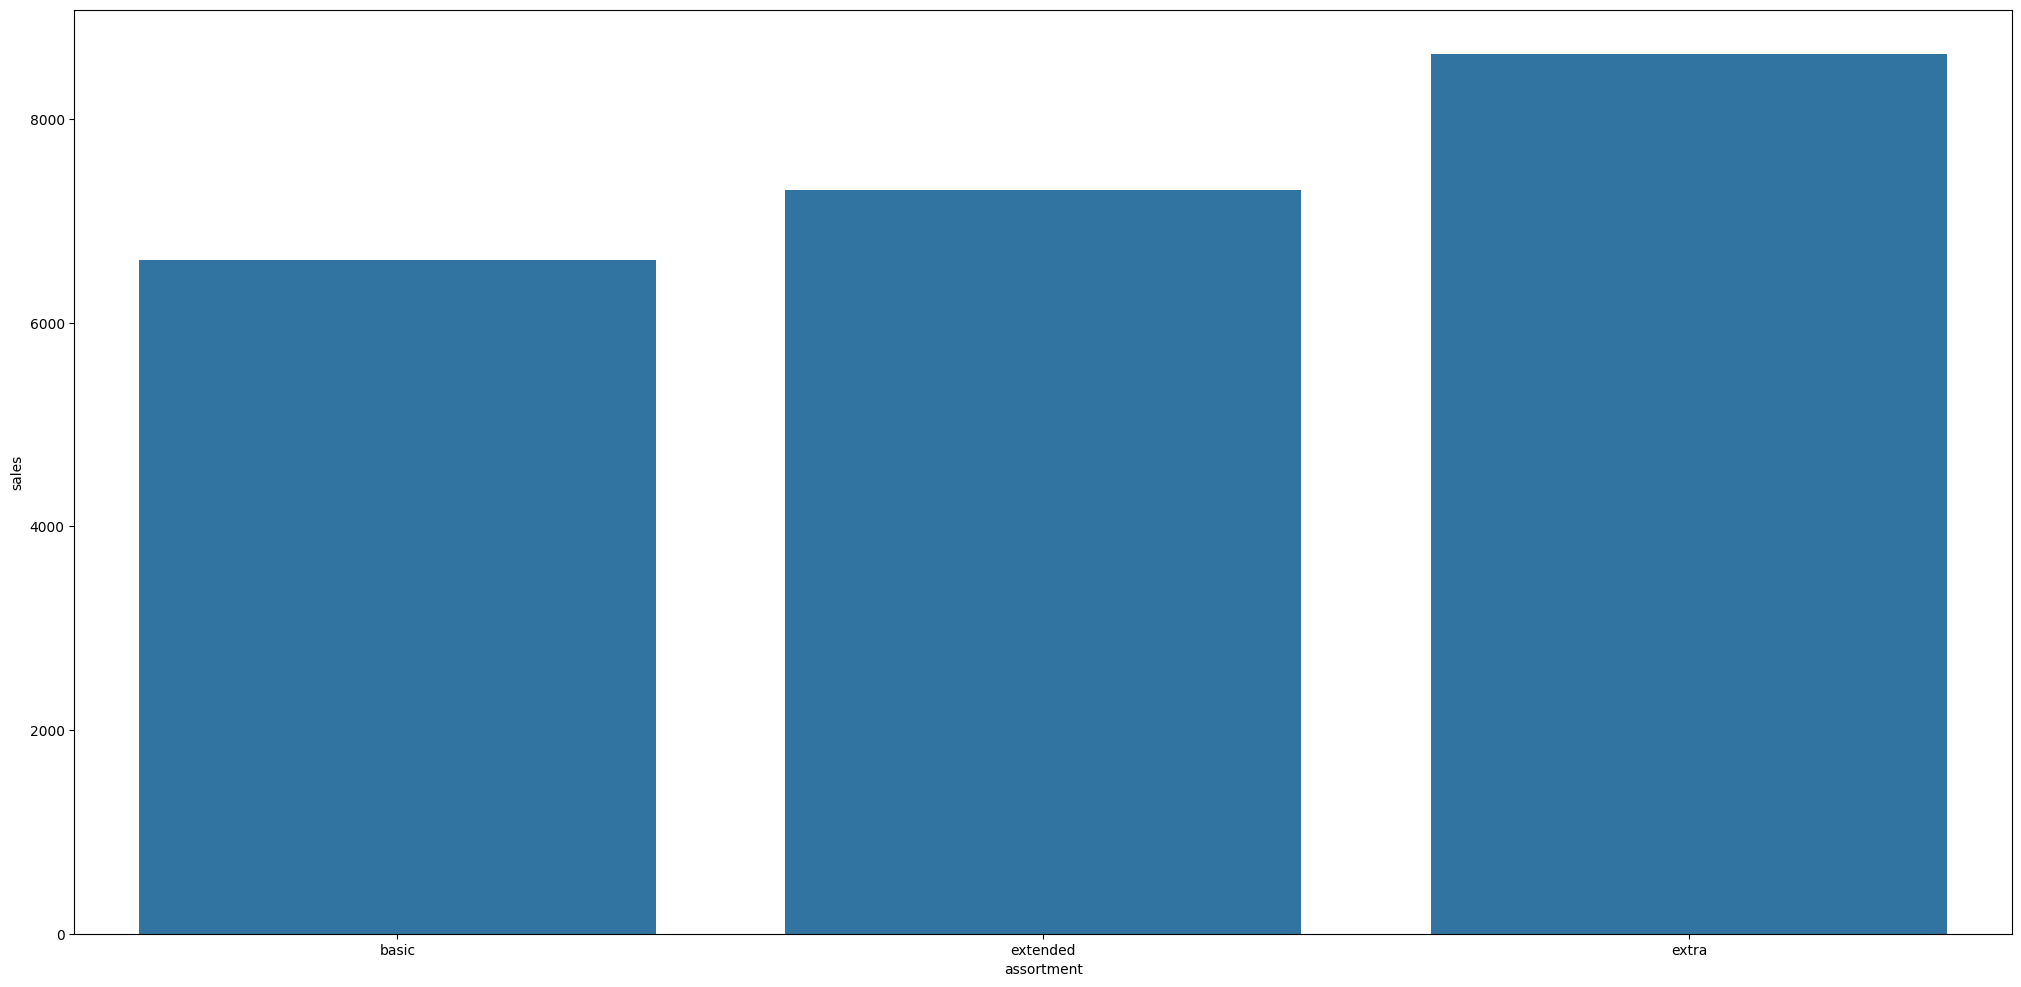

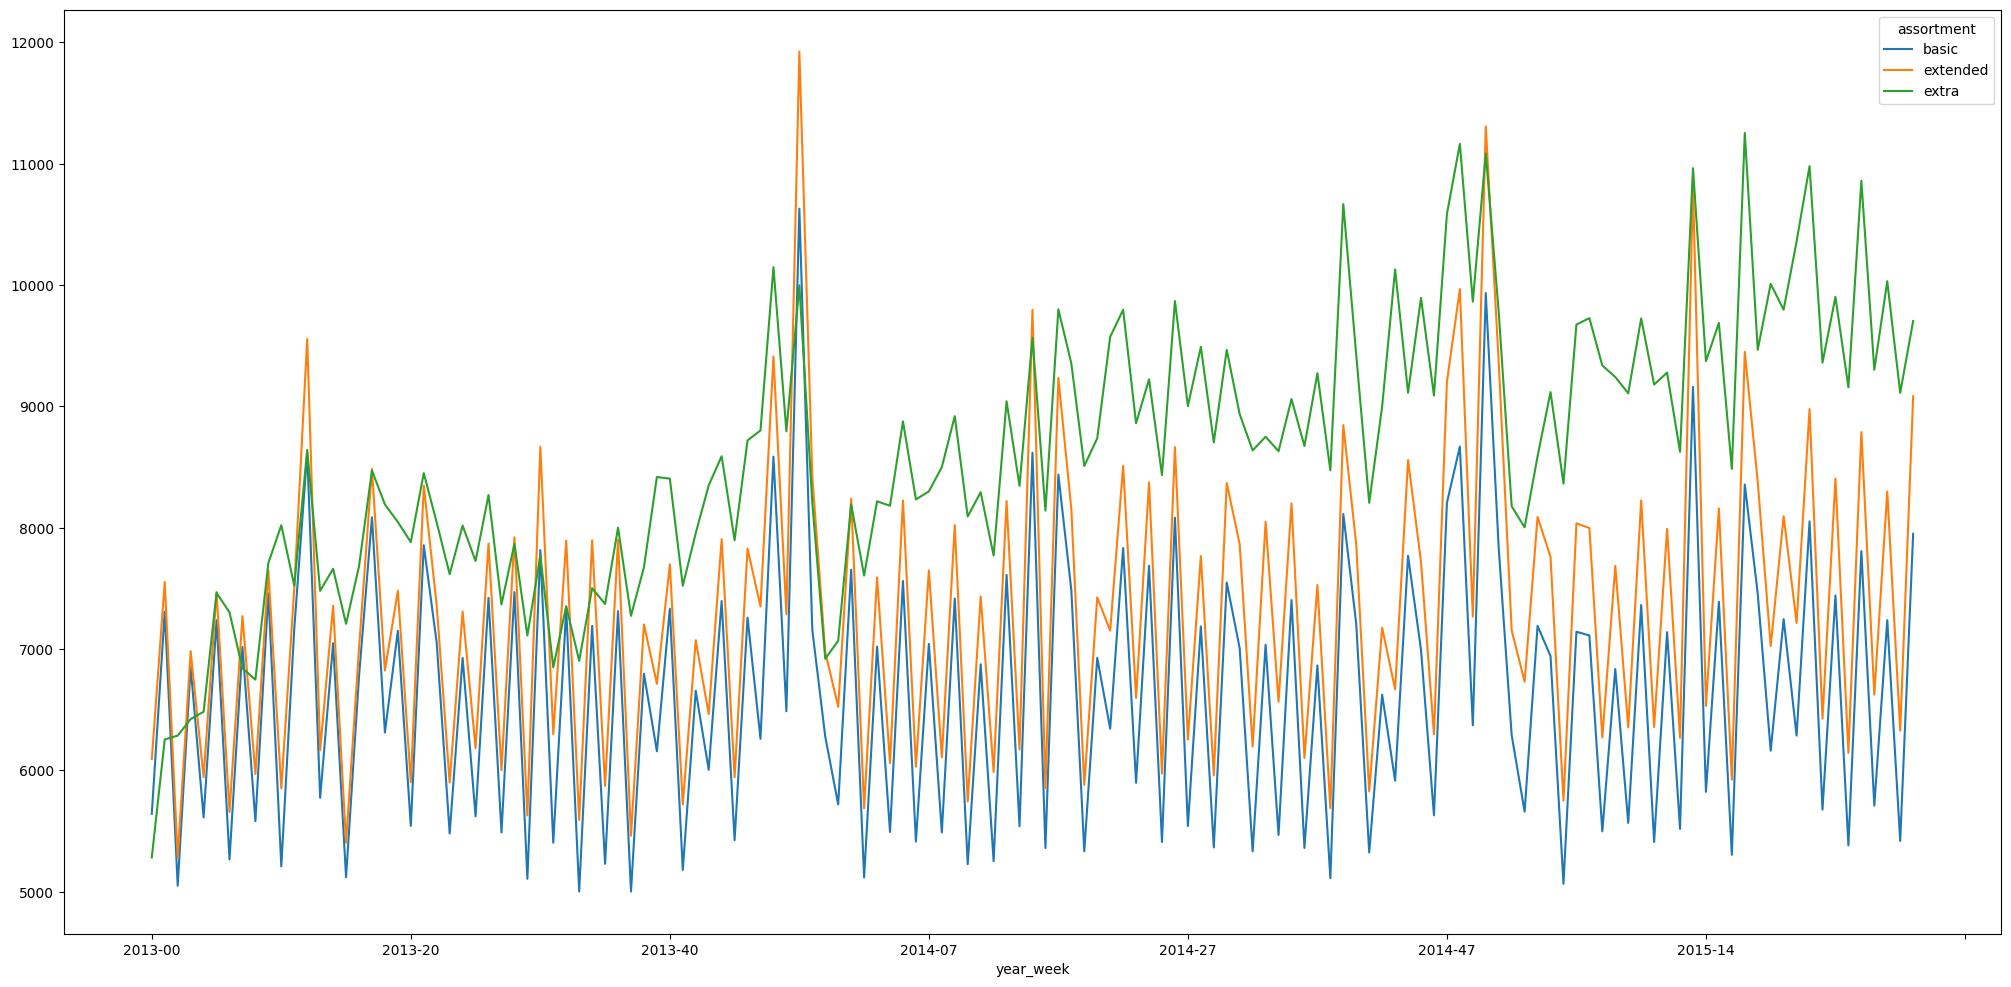

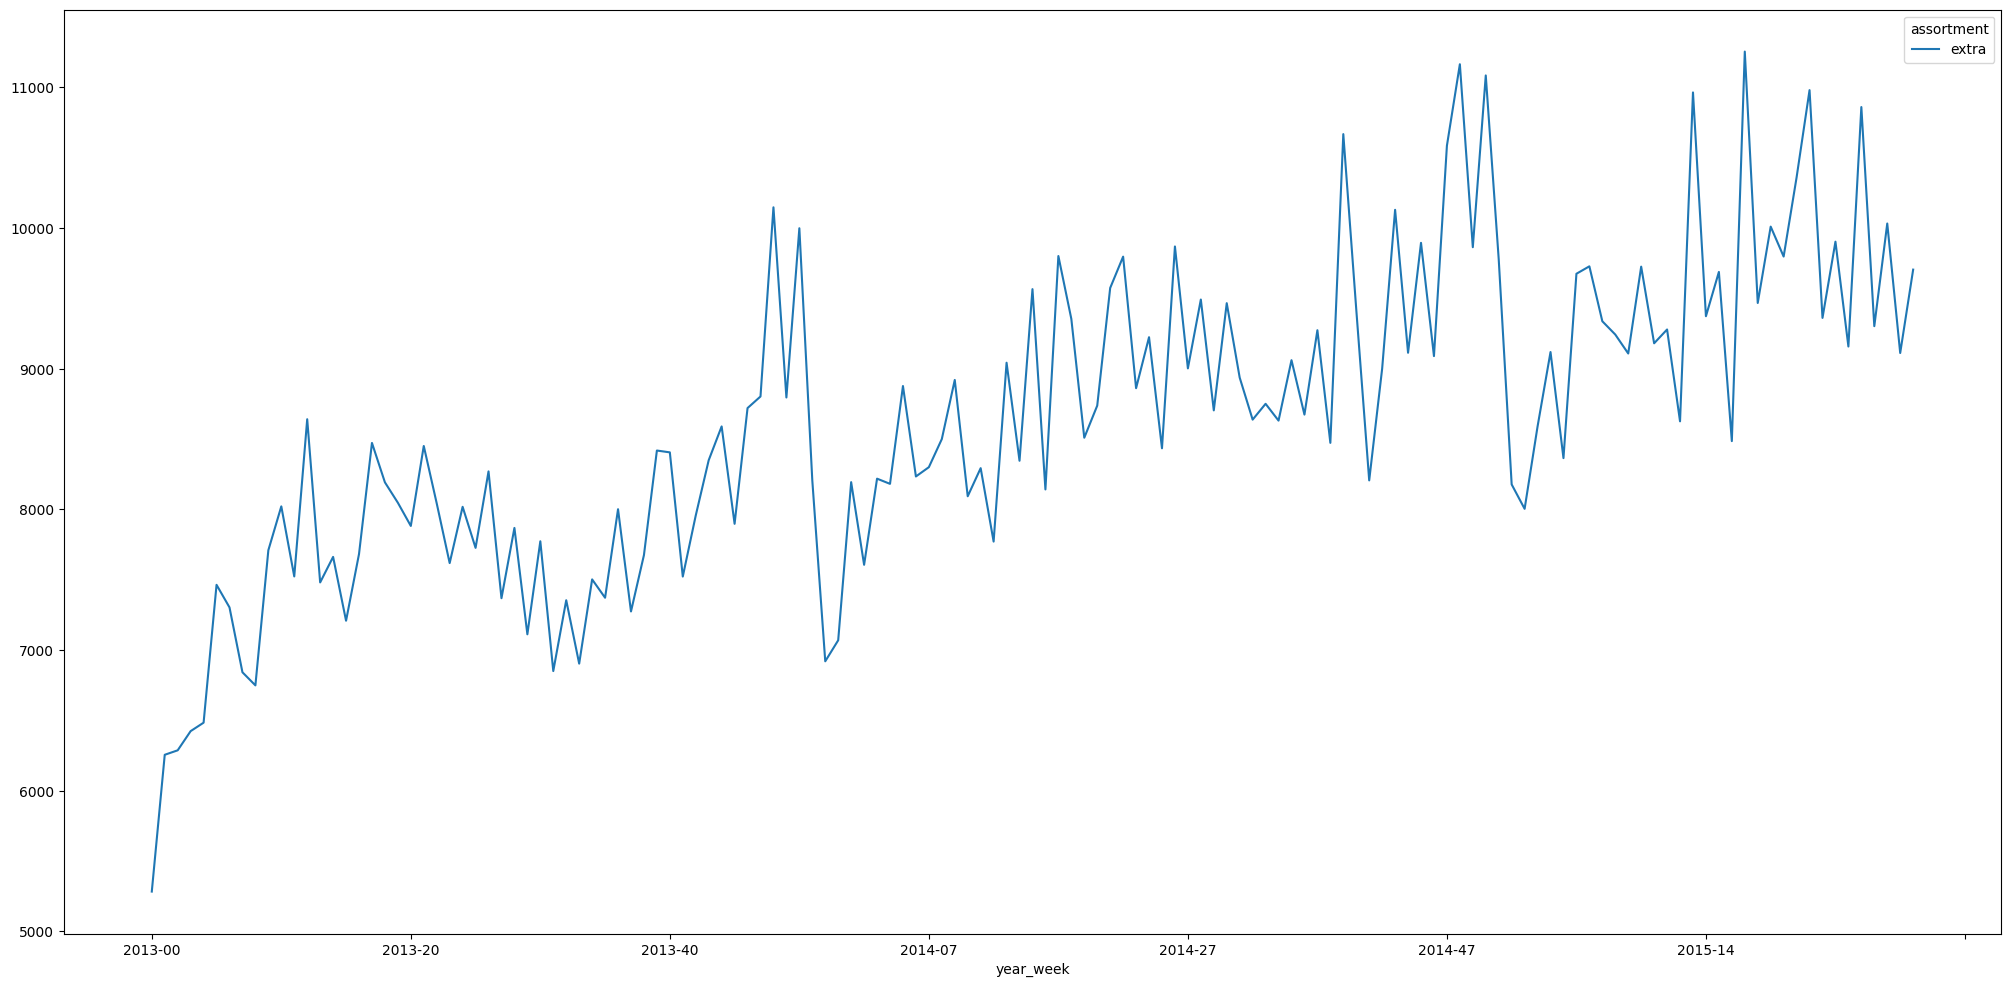

In [44]:
aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).mean().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 );

aux2 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week','assortment'] ).mean().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot()

### True

In [60]:
print(aux1.dtypes)


competition_distance            float64
sales                           float64
competition_distance_binned    category
dtype: object


### H2. Stores with nearer competitors should sell less

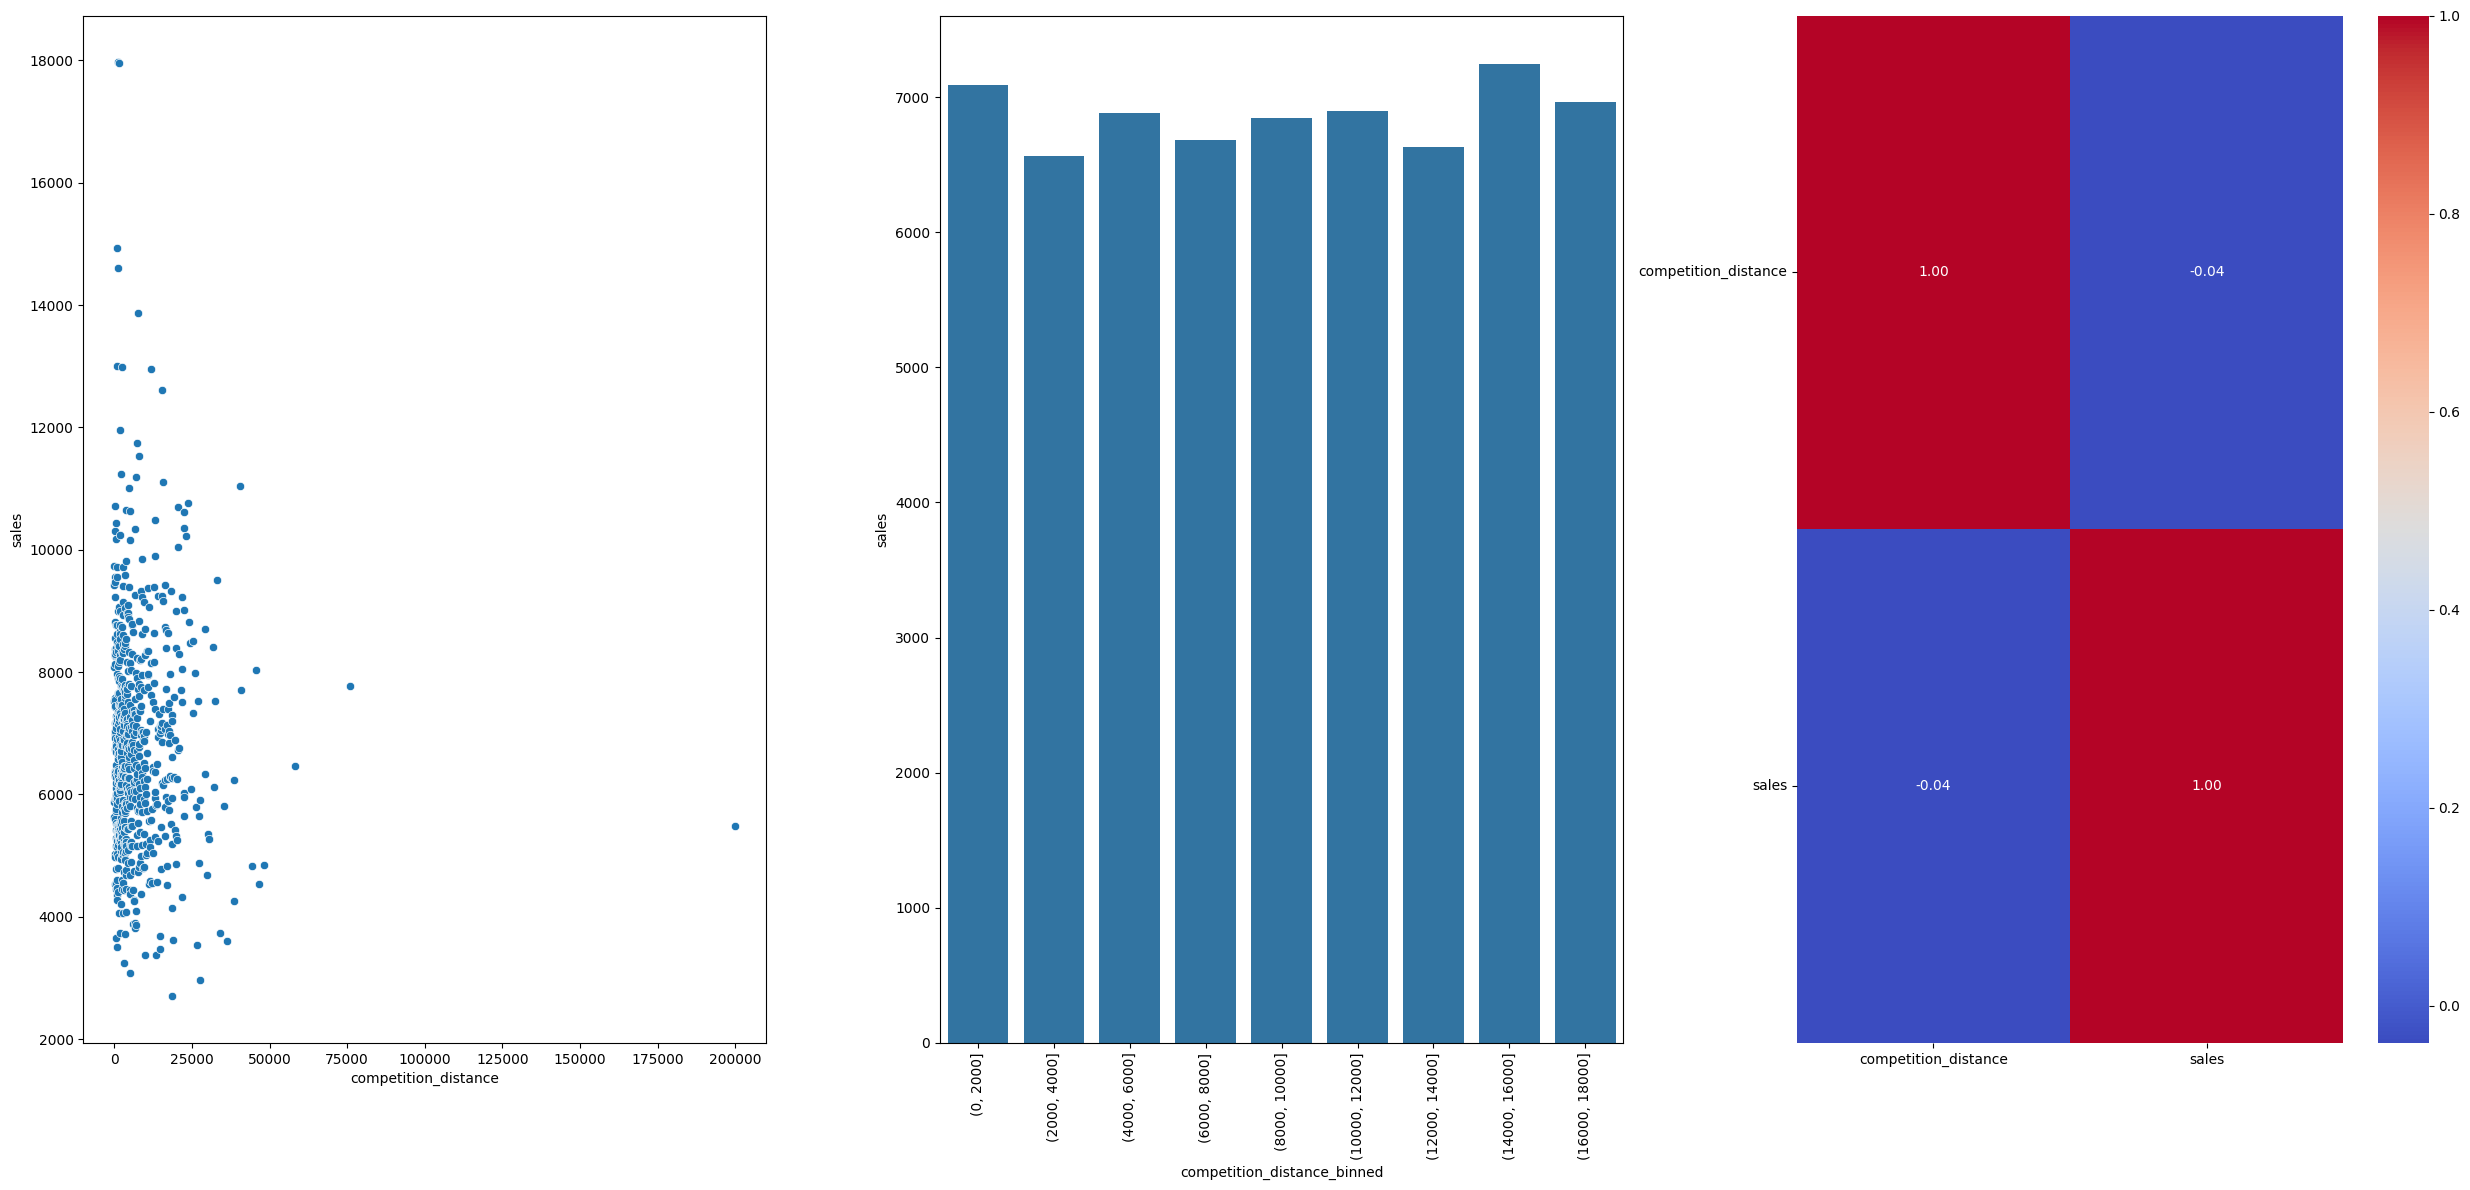

In [62]:
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).mean().reset_index()

# Subplot 1: Scatter plot
plt.subplot( 1, 3, 1 )
sns.scatterplot( x ='competition_distance', y='sales', data=aux1 );

# Subplot 2: Bar plot
plt.subplot( 1, 3, 2 )
bins = list( np.arange( 0, 20000, 2000) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).mean().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
plt.xticks( rotation=90 );

# Subplot 3: Heatmap
plt.subplot(1, 3, 3)
corr_matrix = aux1[['competition_distance', 'sales']].corr(method='pearson')
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.yticks(rotation=0)  # Adjust y-axis ticks rotation

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

### False

### H3. Stores with competitors for longer time should sell more

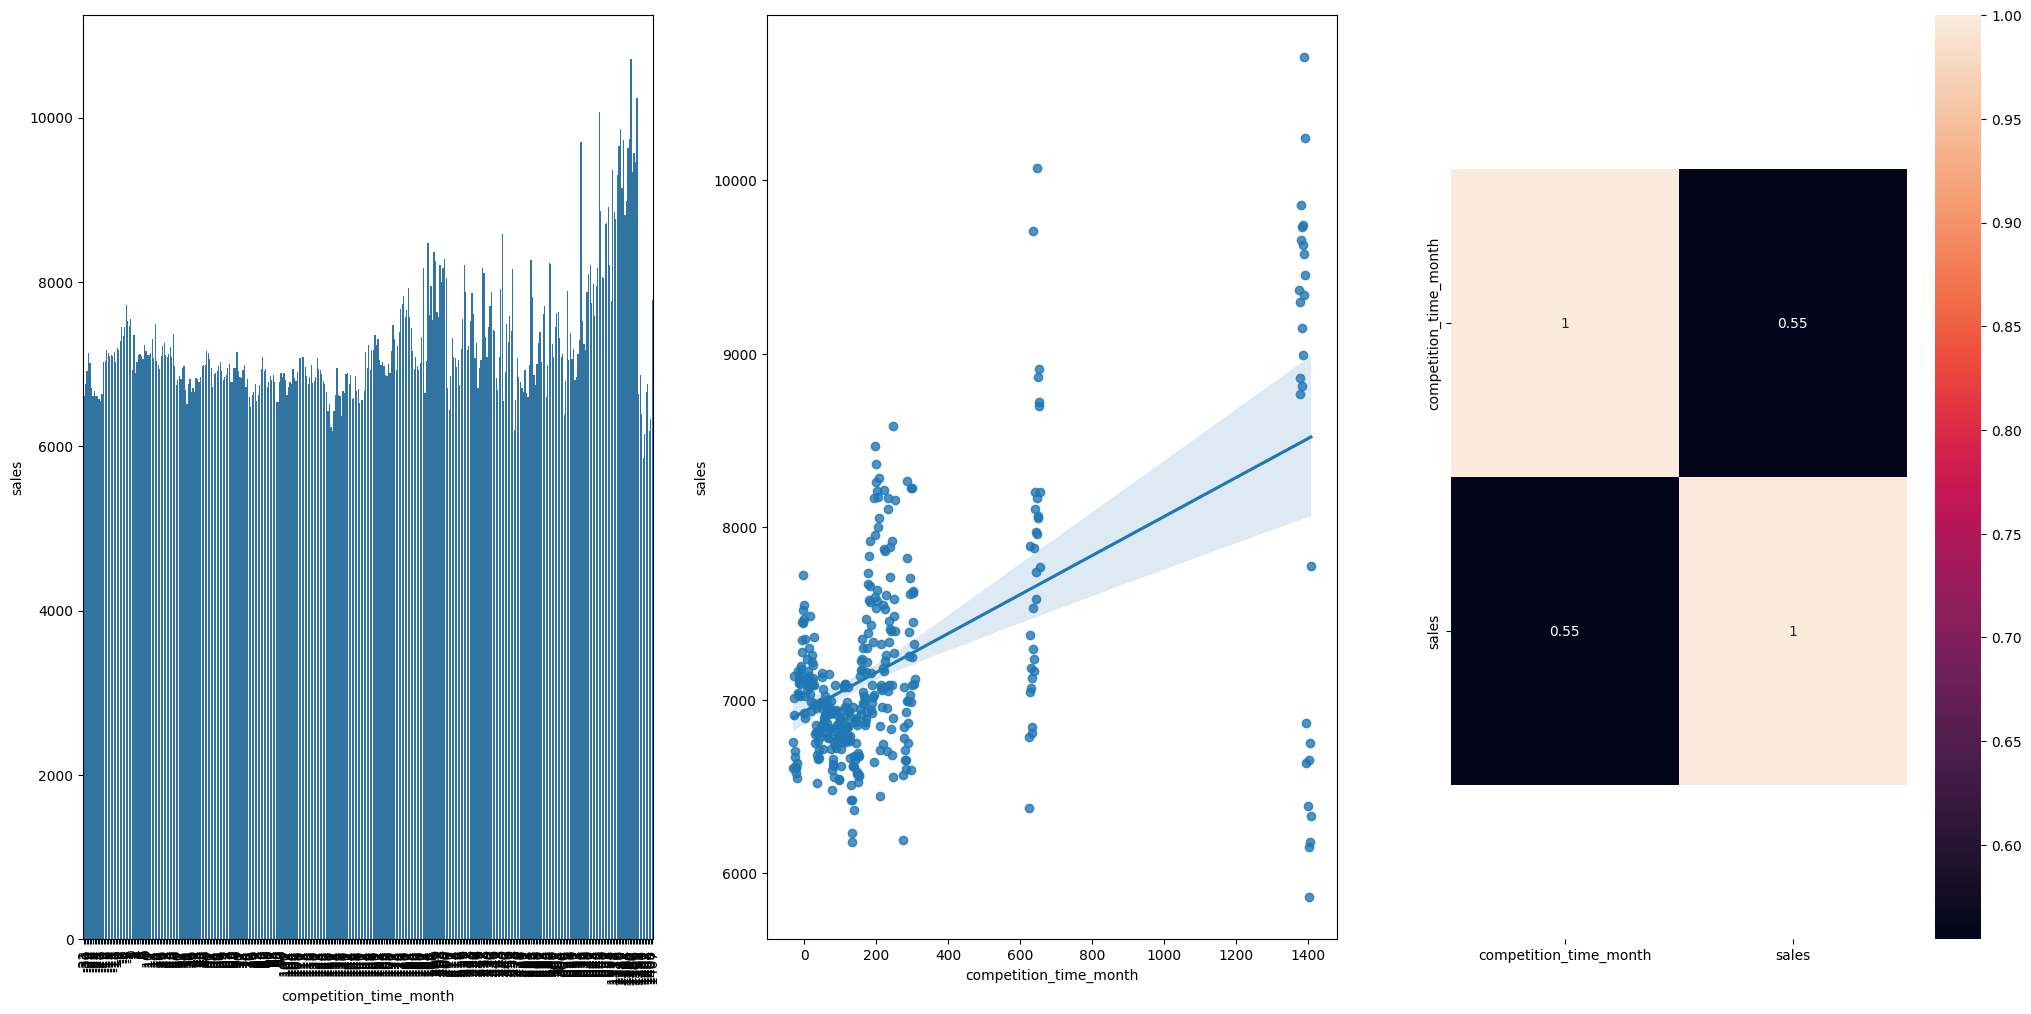

In [63]:
plt.subplot( 1, 3, 1 )
aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).mean().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 )]
sns.barplot( x='competition_time_month', y='sales', data=aux1 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='competition_time_month', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson'), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5);

### True

### H4. Stores with promotions active for longer periods should sell more

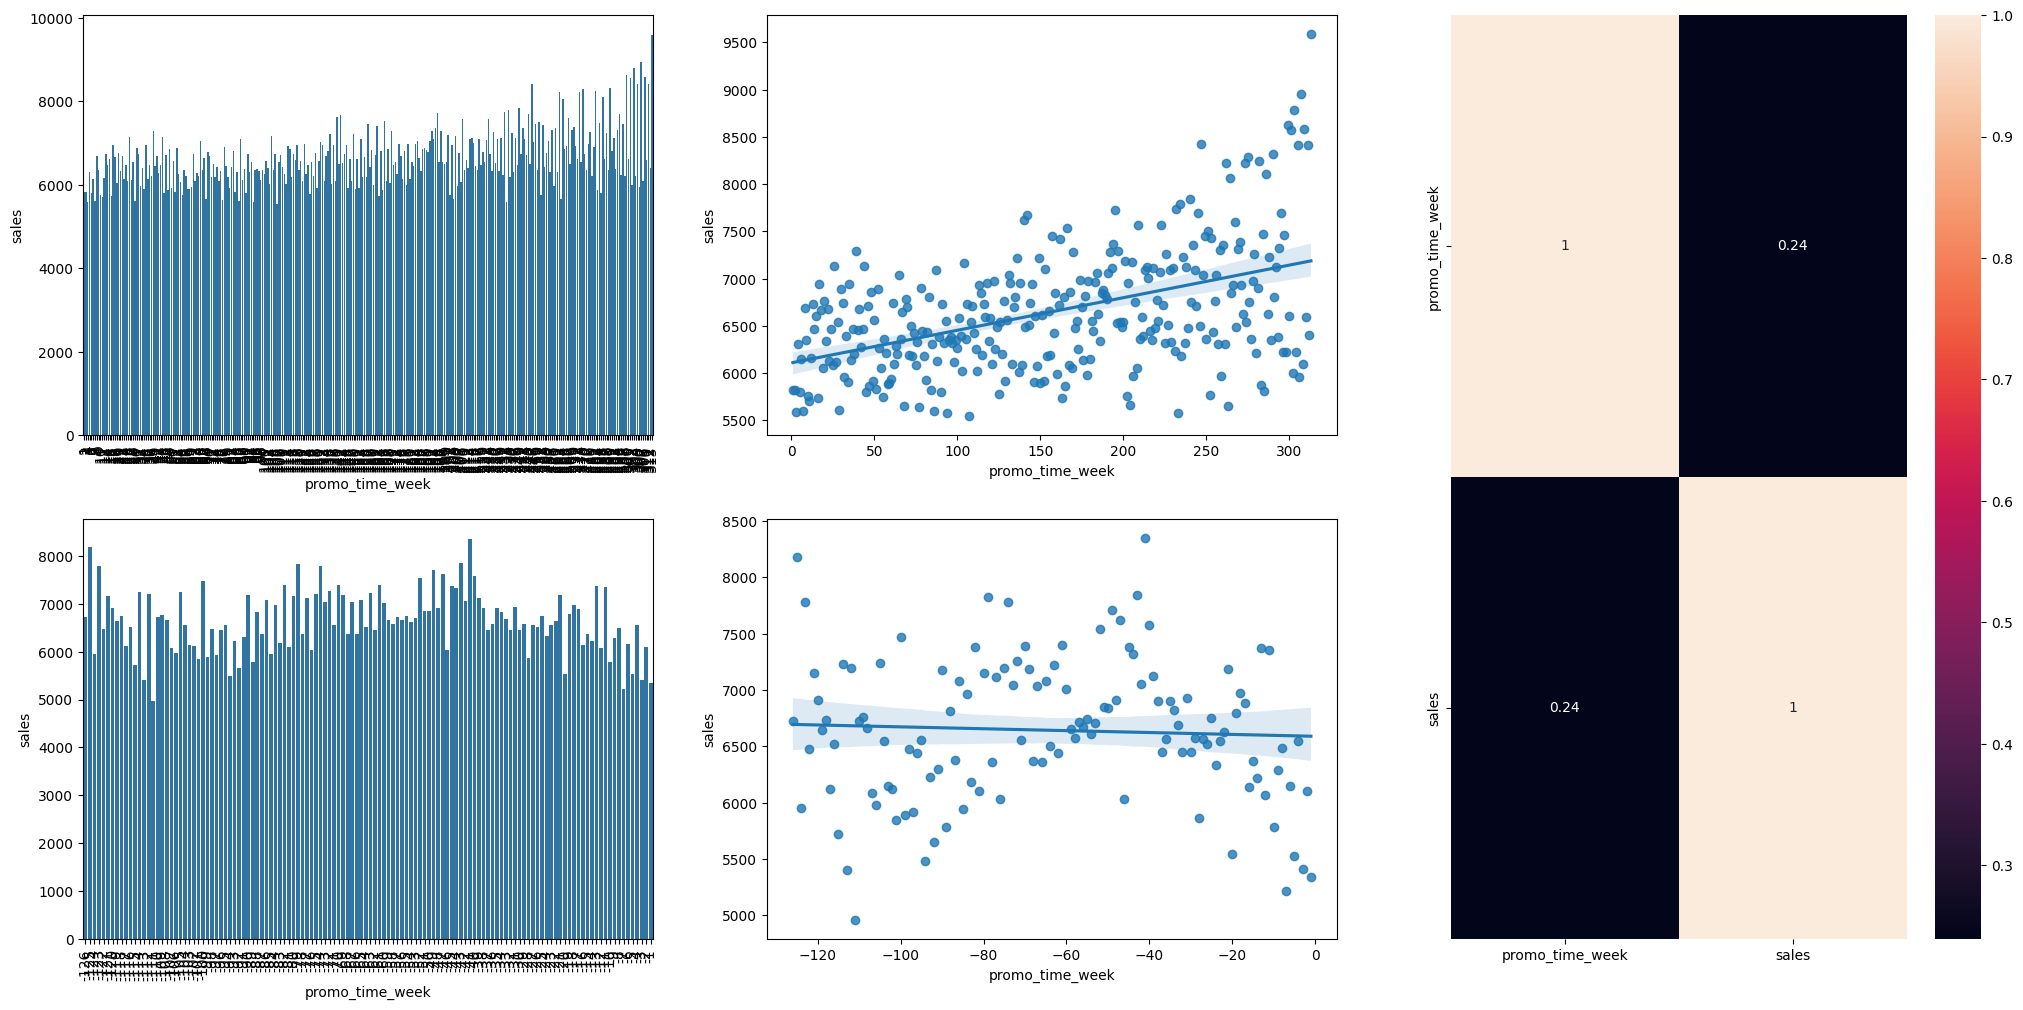

In [64]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').mean().reset_index()

grid = GridSpec( 2, 3 )

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### True

### H5. Stores with more consecutive promotions should sell more.

In [65]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).mean().reset_index()

,promo,promo2,sales
0,0,0,6328.187633
1,0,1,5529.566684
2,1,0,8618.452062
3,1,1,7836.672987


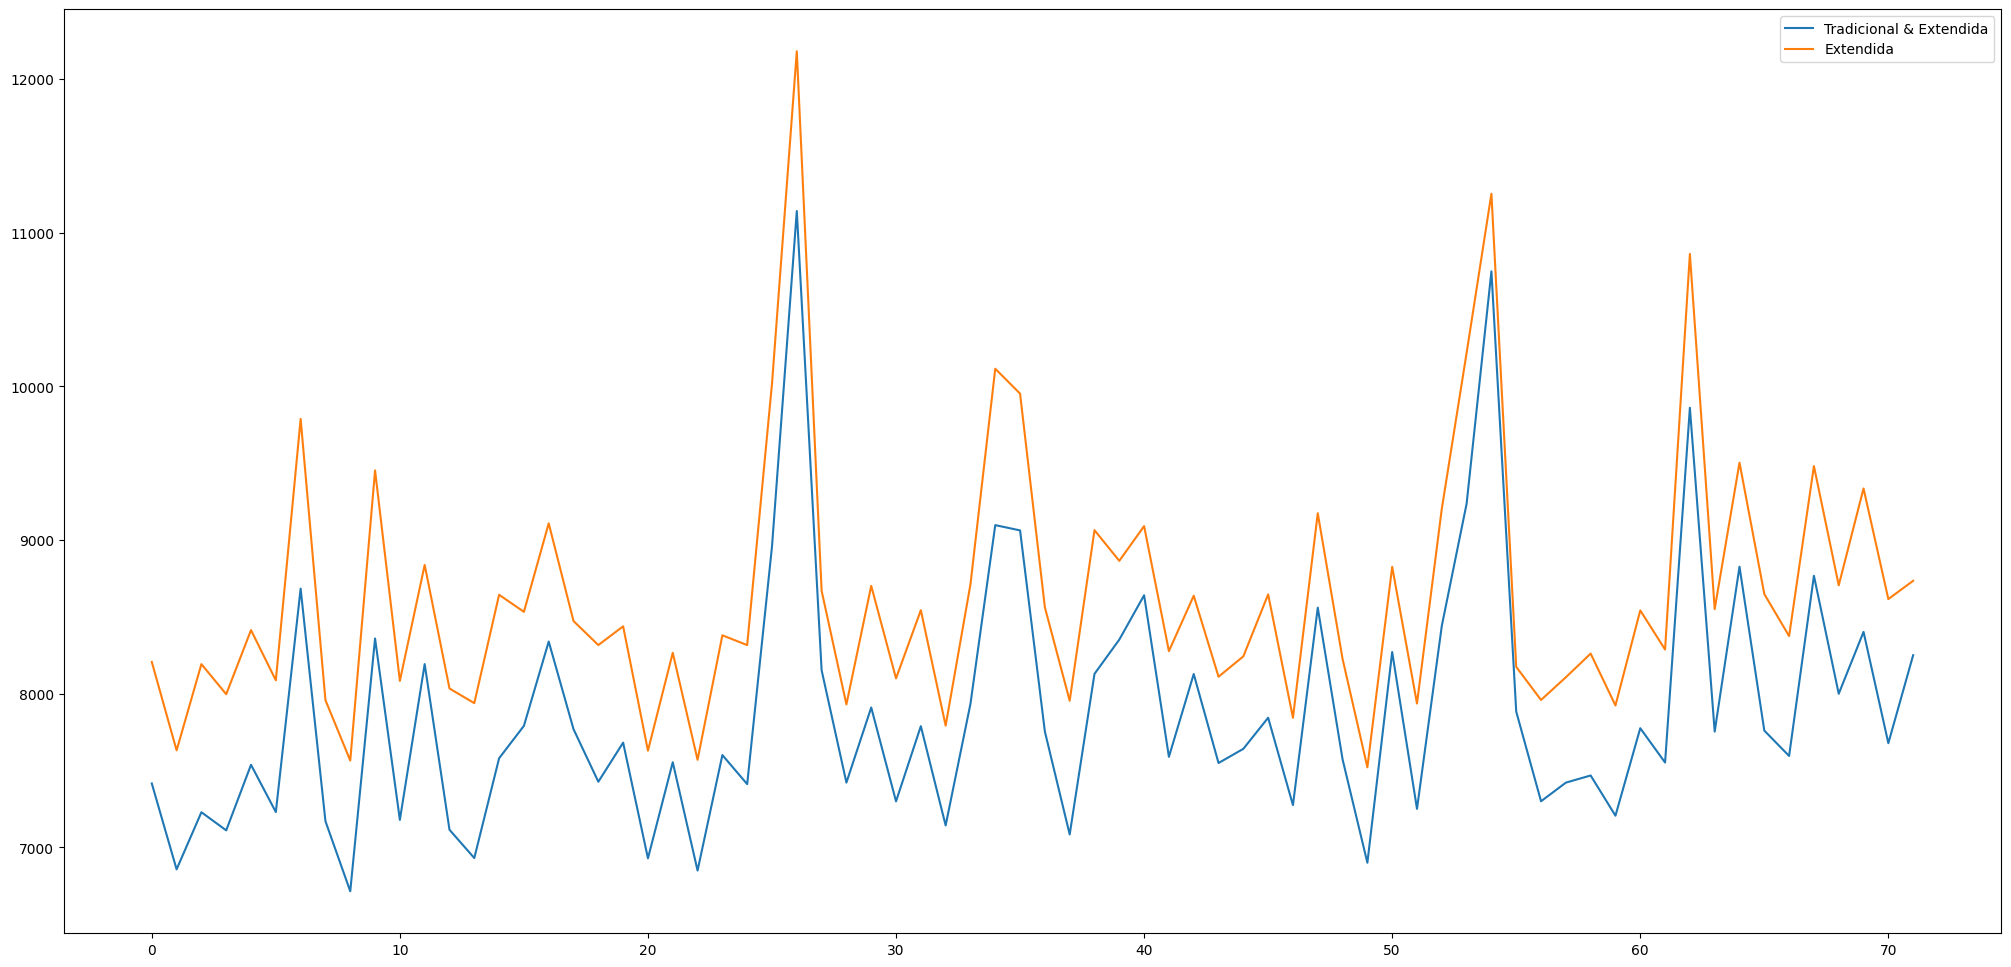

In [66]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week' ).mean().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).mean().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Tradicional & Extendida', 'Extendida']);

### False

### H6. Stores open during the Christmas holiday should sell more.

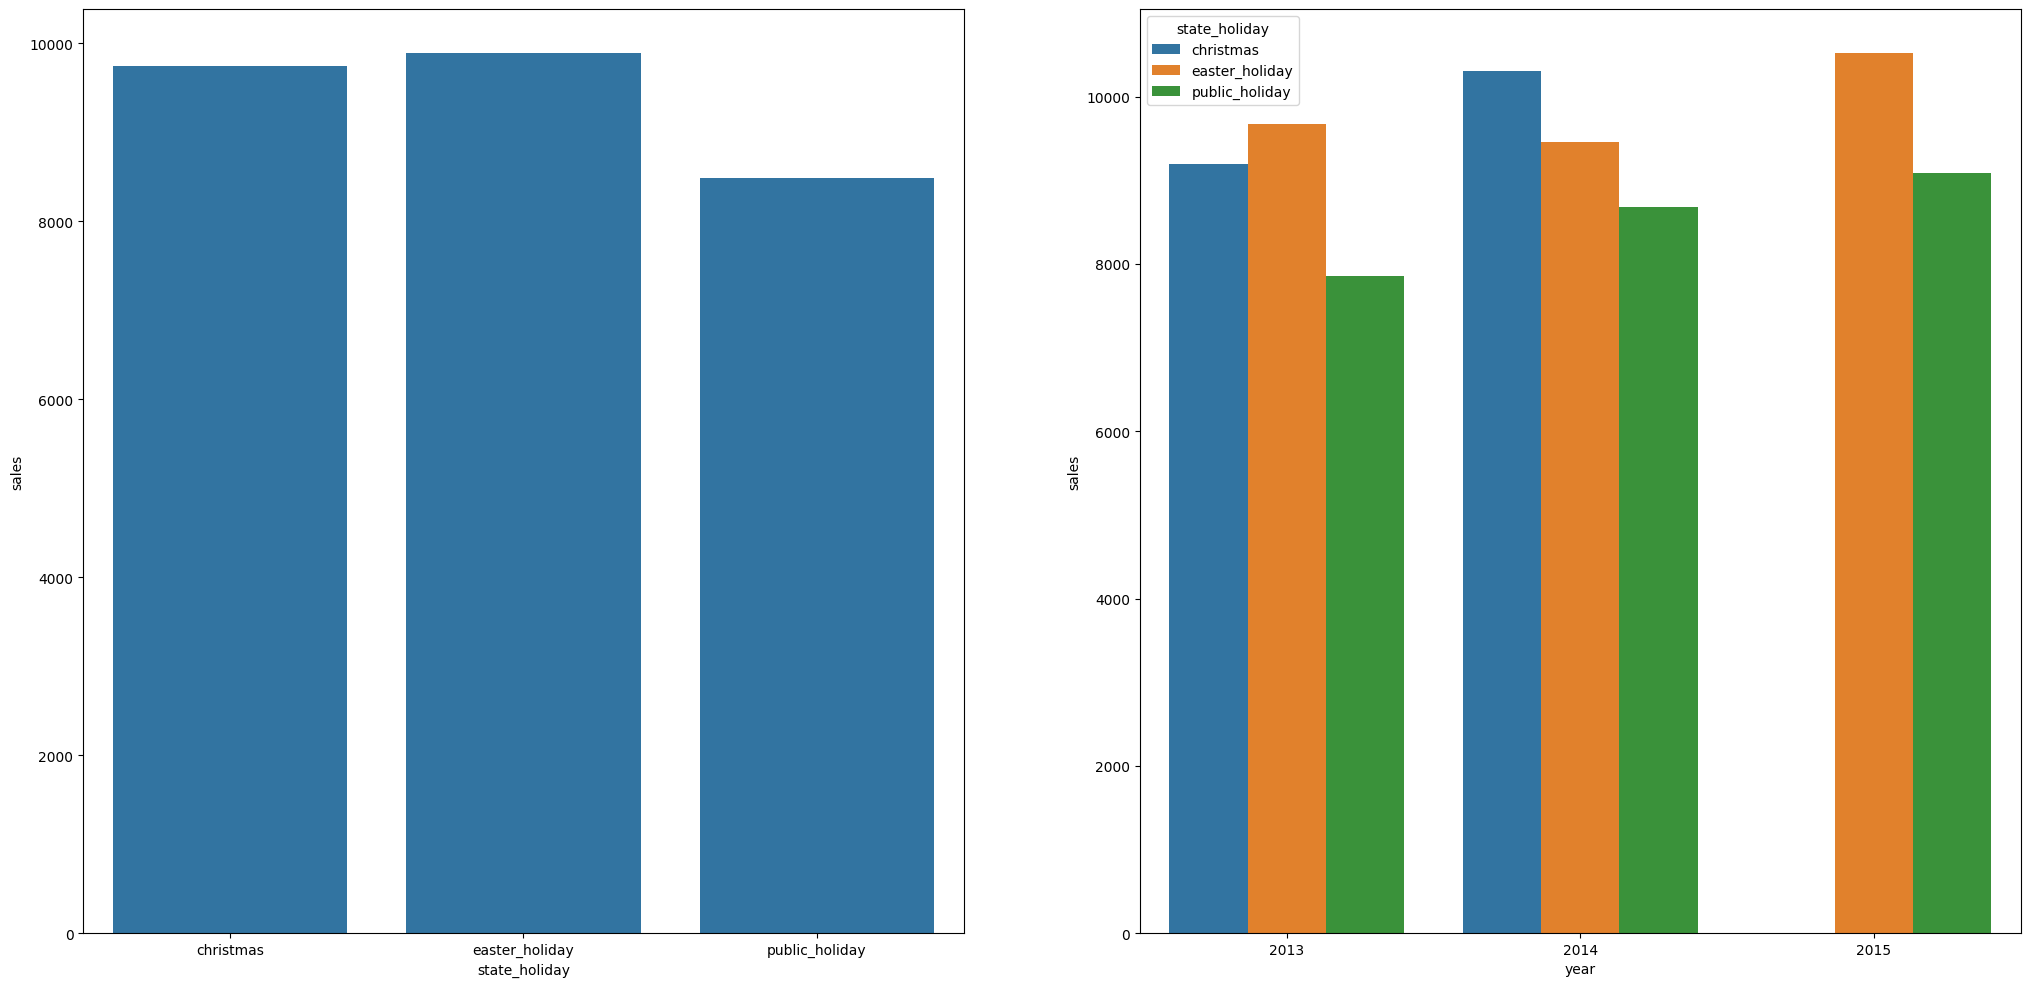

In [67]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).mean().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );

plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).mean().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );

### False

### H7. Stores should sell more over the years.

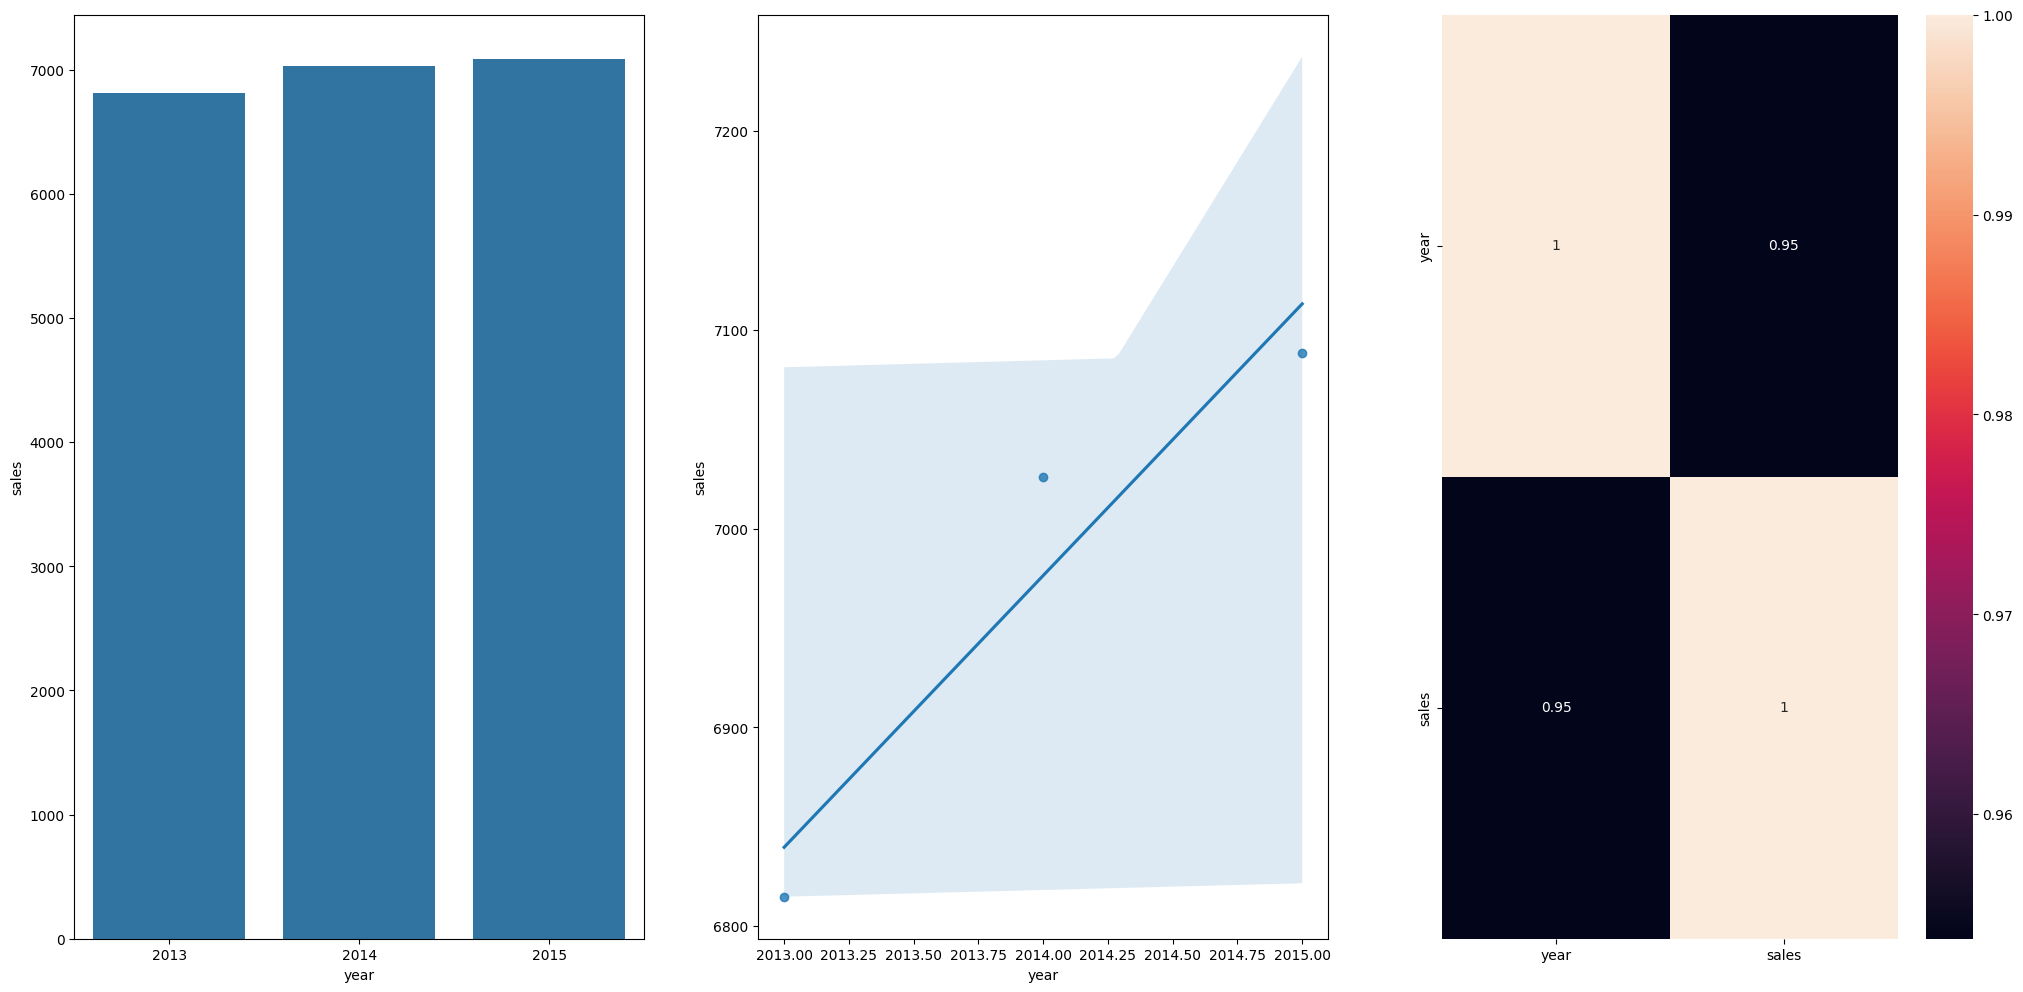

In [68]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).mean().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### True

### H8. Stores should sell more in the second half of the year.

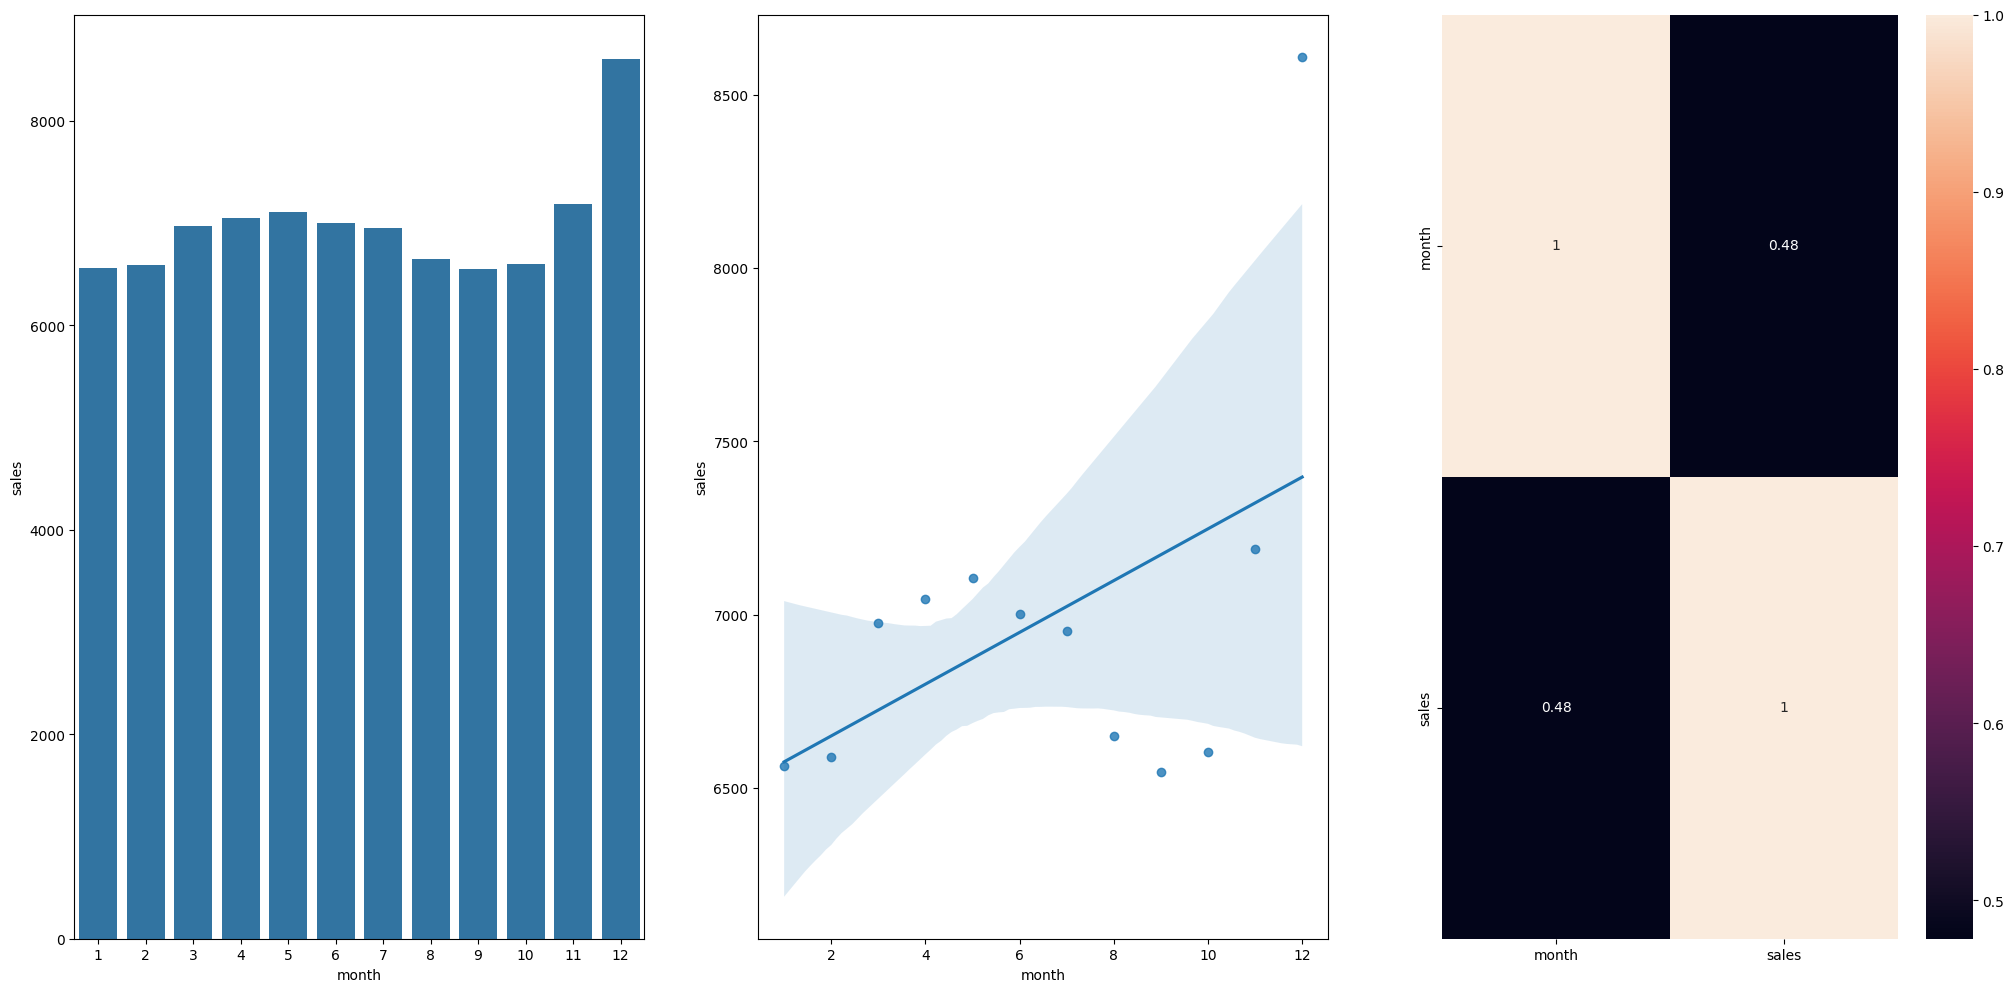

In [69]:
aux1 = df4[['month', 'sales']].groupby( 'month' ).mean().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### True

### H9. Stores should sell more after the 10th of each month.

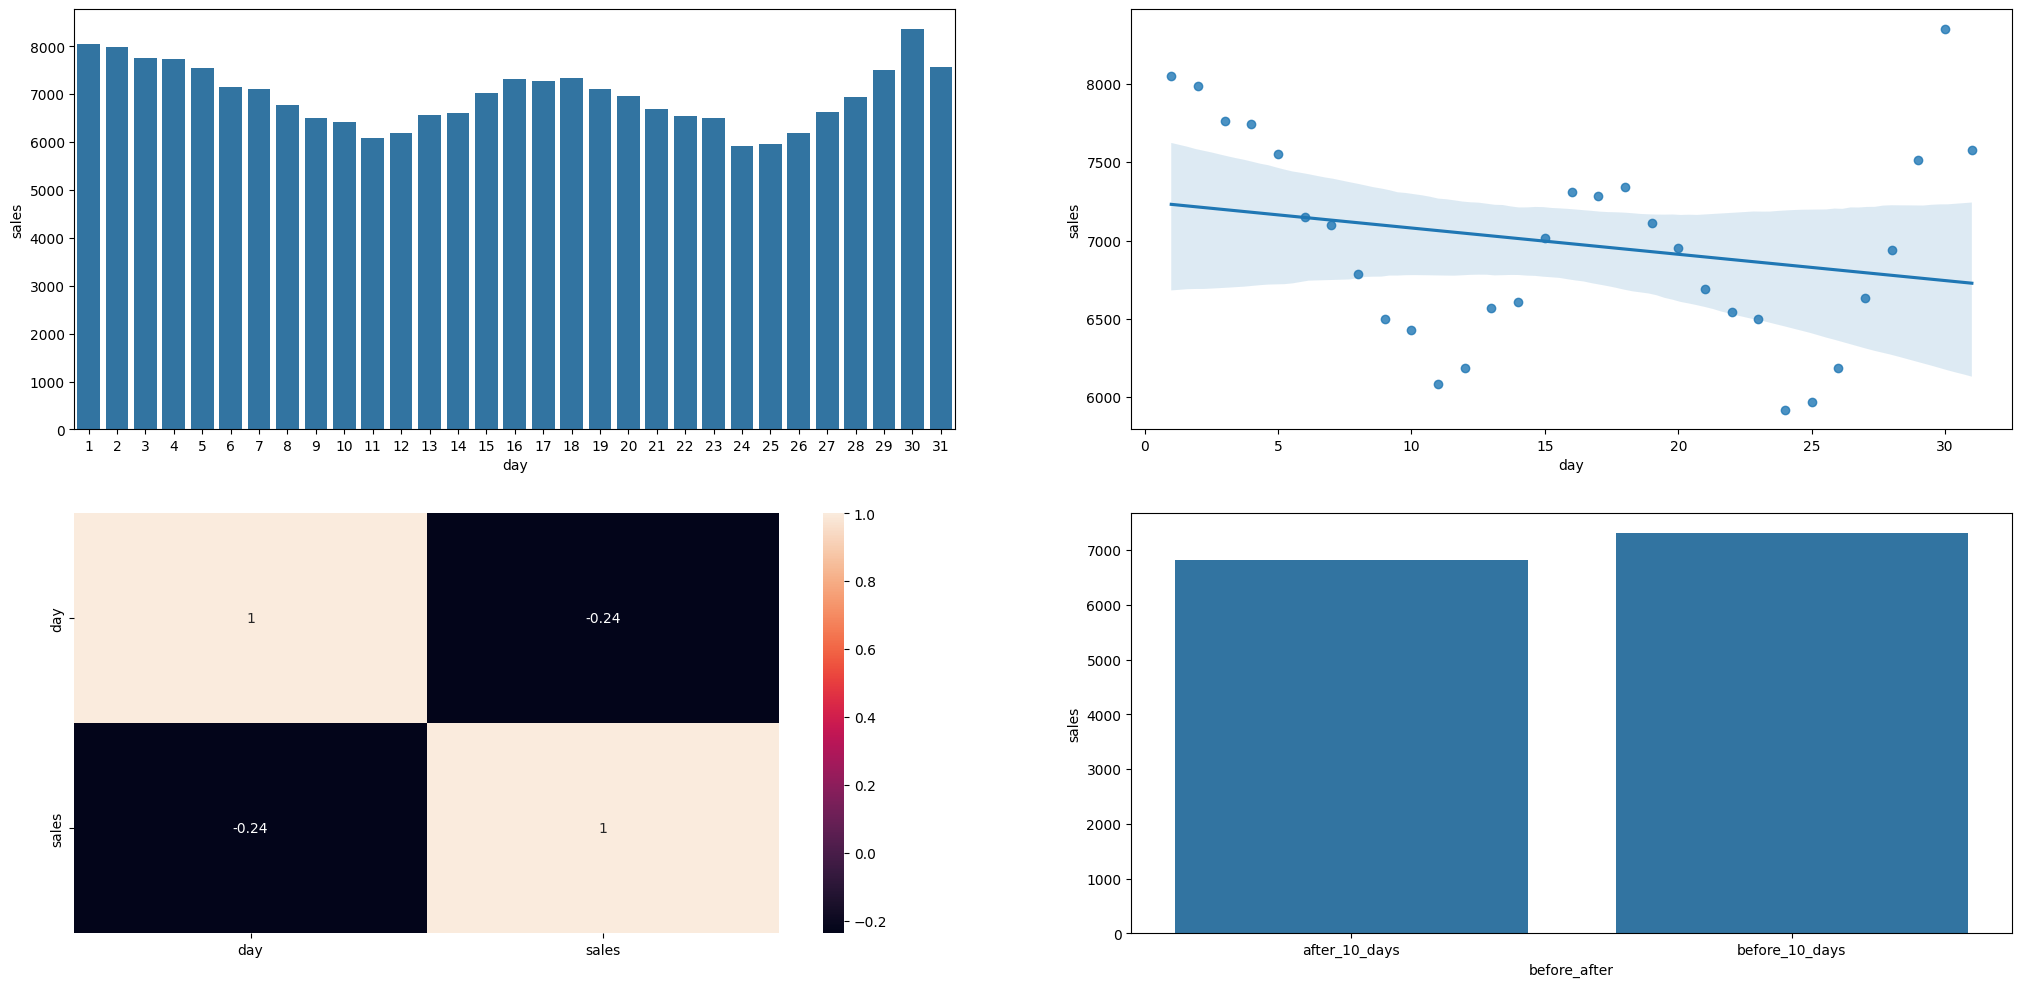

In [70]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).mean().reset_index()

plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 =aux1[['before_after', 'sales']].groupby( 'before_after' ).mean().reset_index()

plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='sales', data=aux2 );

### False

### H10. Stores should sell less on weekends.

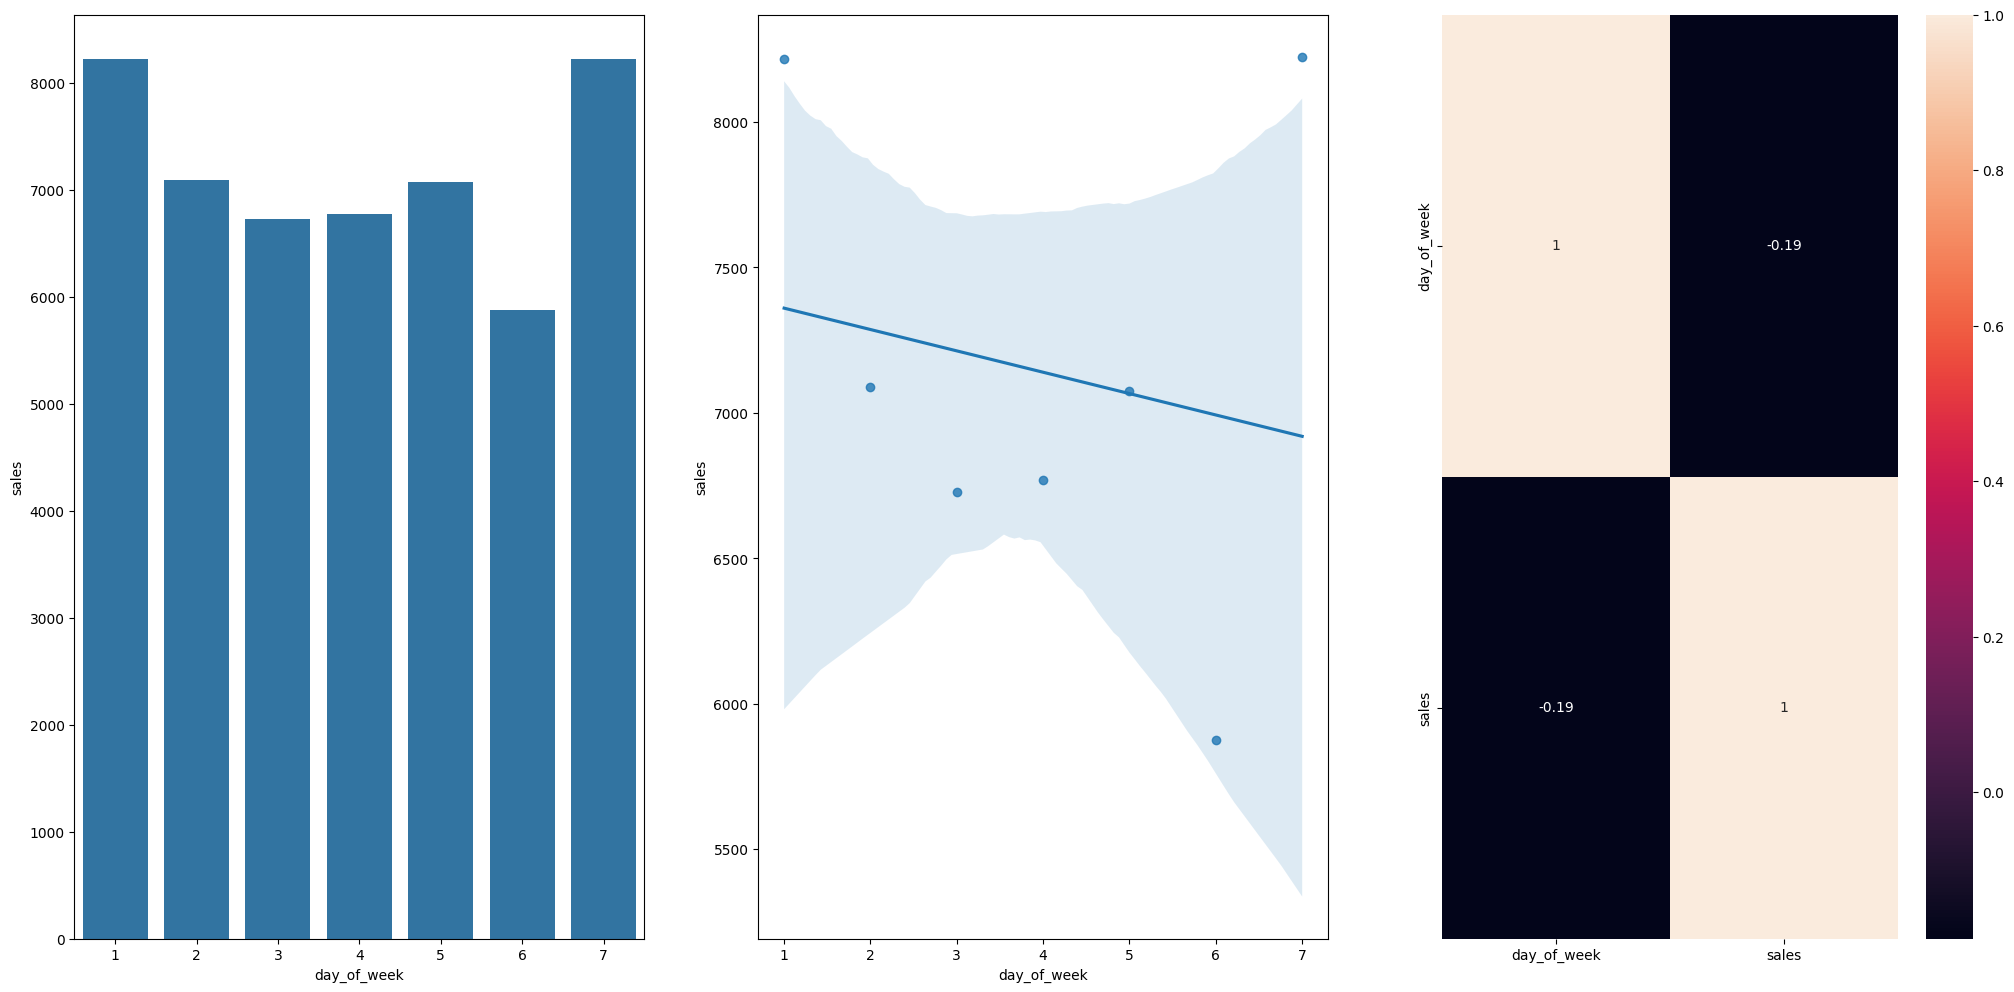

In [71]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).mean().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### False

### H11. Stores should sell less during school holidays.

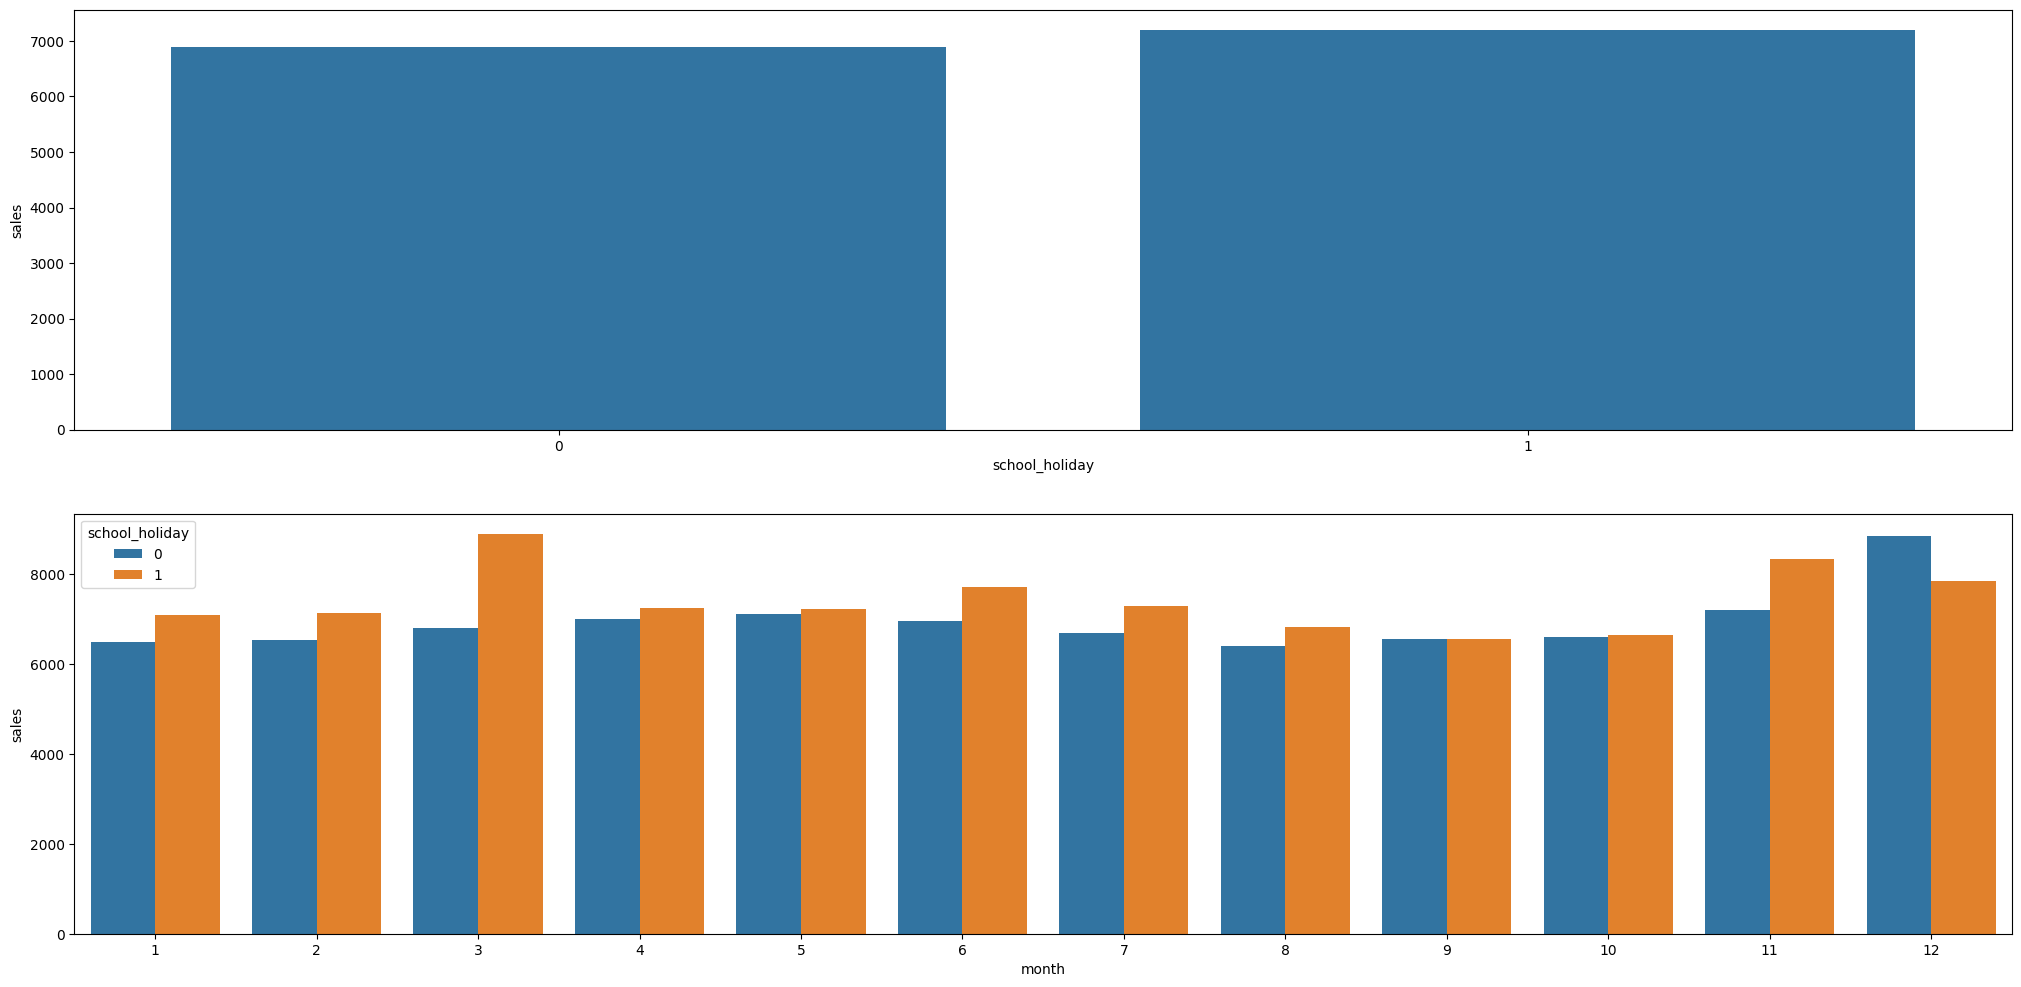

In [72]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).mean().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );

aux2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month','school_holiday'] ).mean().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );

### False

### 4.2.1. Hypothesis Summary

In [73]:
tab =[['Hypothesis', 'Conclusion'],
      ['H1', 'True'],  
      ['H2', 'False'],  
      ['H3', 'True'],
      ['H4', 'True'],
      ['H5', 'False'],
      ['H6', 'False'],
      ['H7', 'True'],
      ['H8', 'True'],
      ['H9', 'False'],
      ['H10', 'False'],
      ['H11', 'False'],
     ]  
print( tabulate( tab, headers='firstrow' ) )

Hypothesis    Conclusion
------------  ------------
H1            True
H2            False
H3            True
H4            True
H5            False
H6            False
H7            True
H8            True
H9            False
H10           False
H11           False


## 4.3. Multivariate Analysis

### 4.3.1. Numerical Attributes

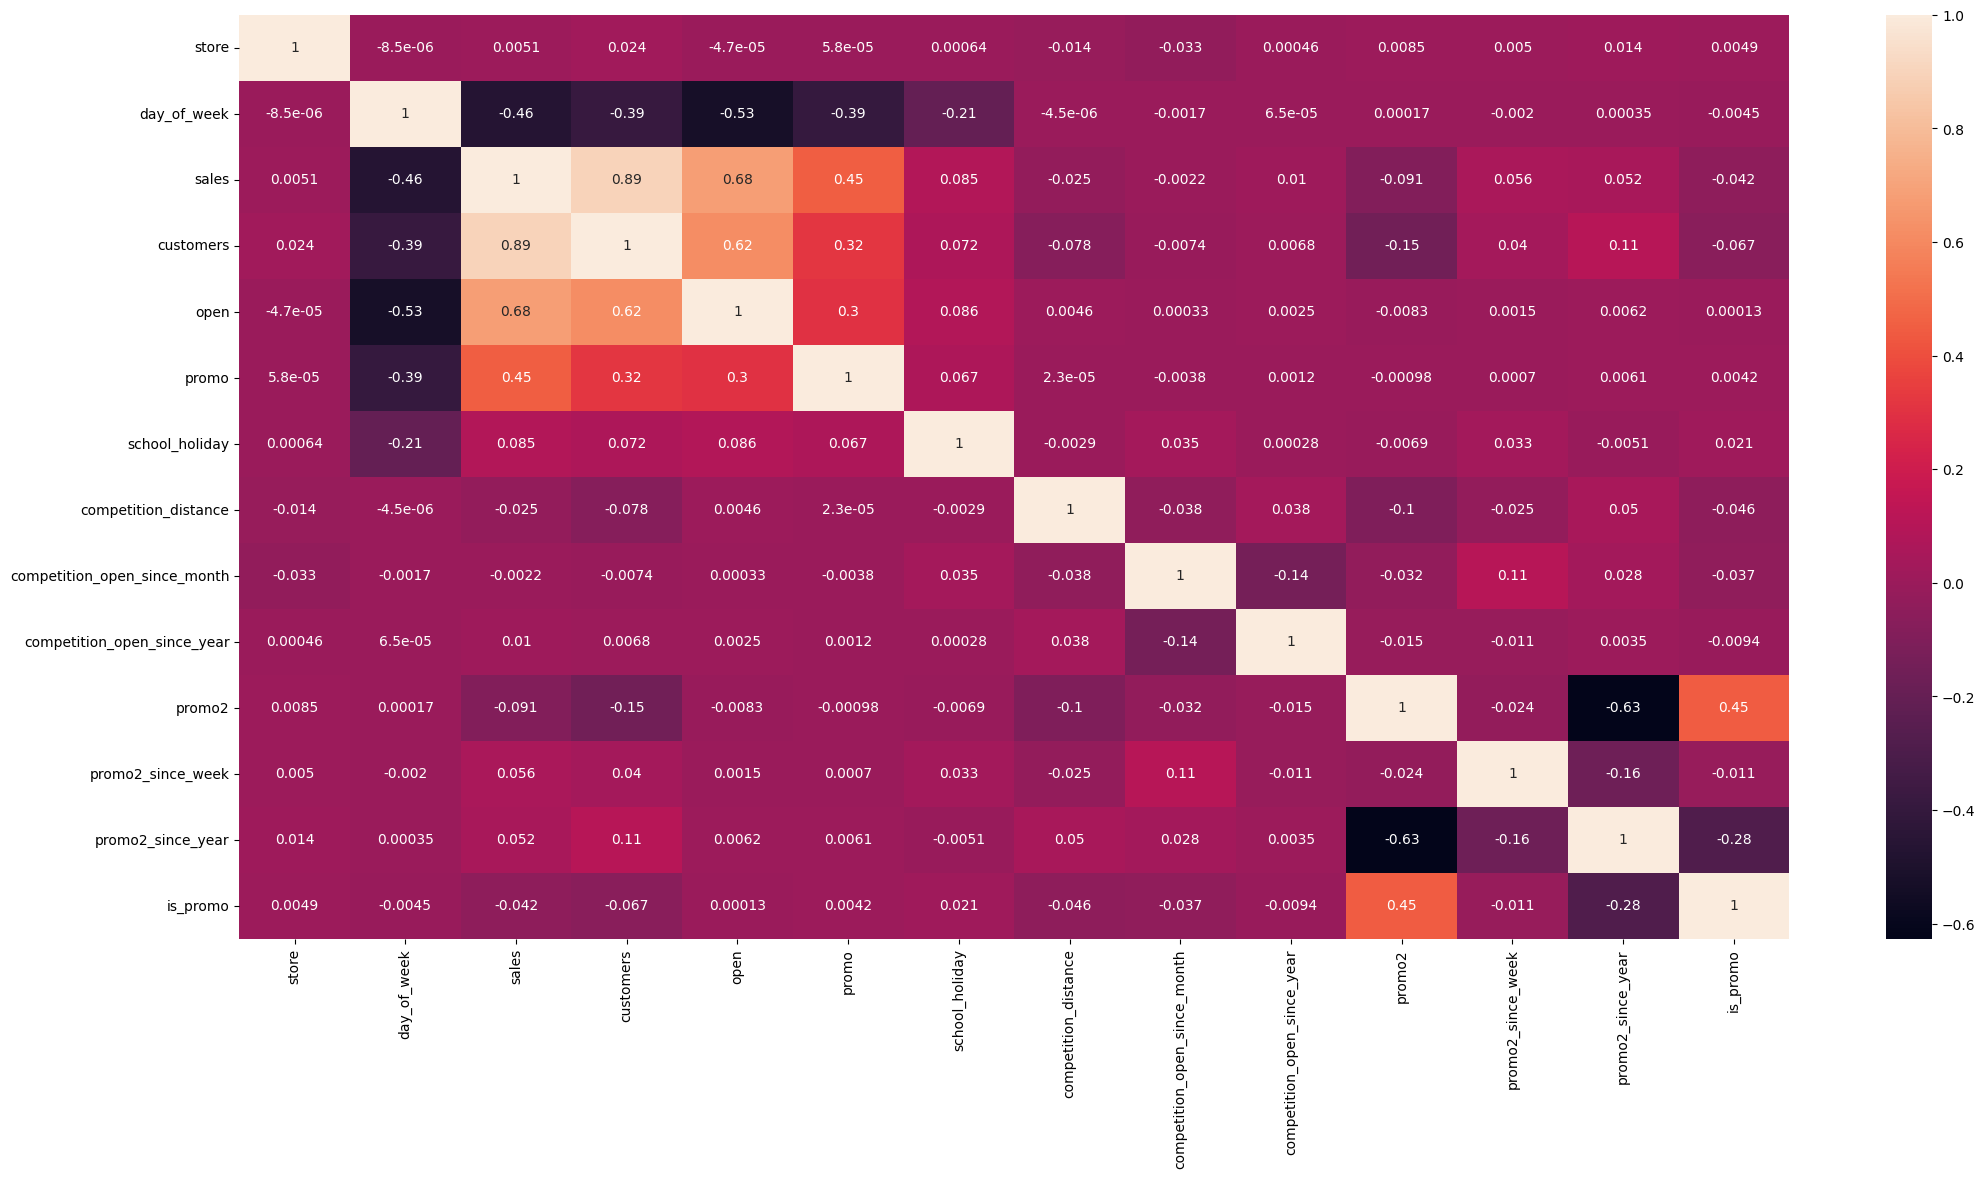

In [74]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

### 4.3.2. Categorical Attributes

<Axes: >

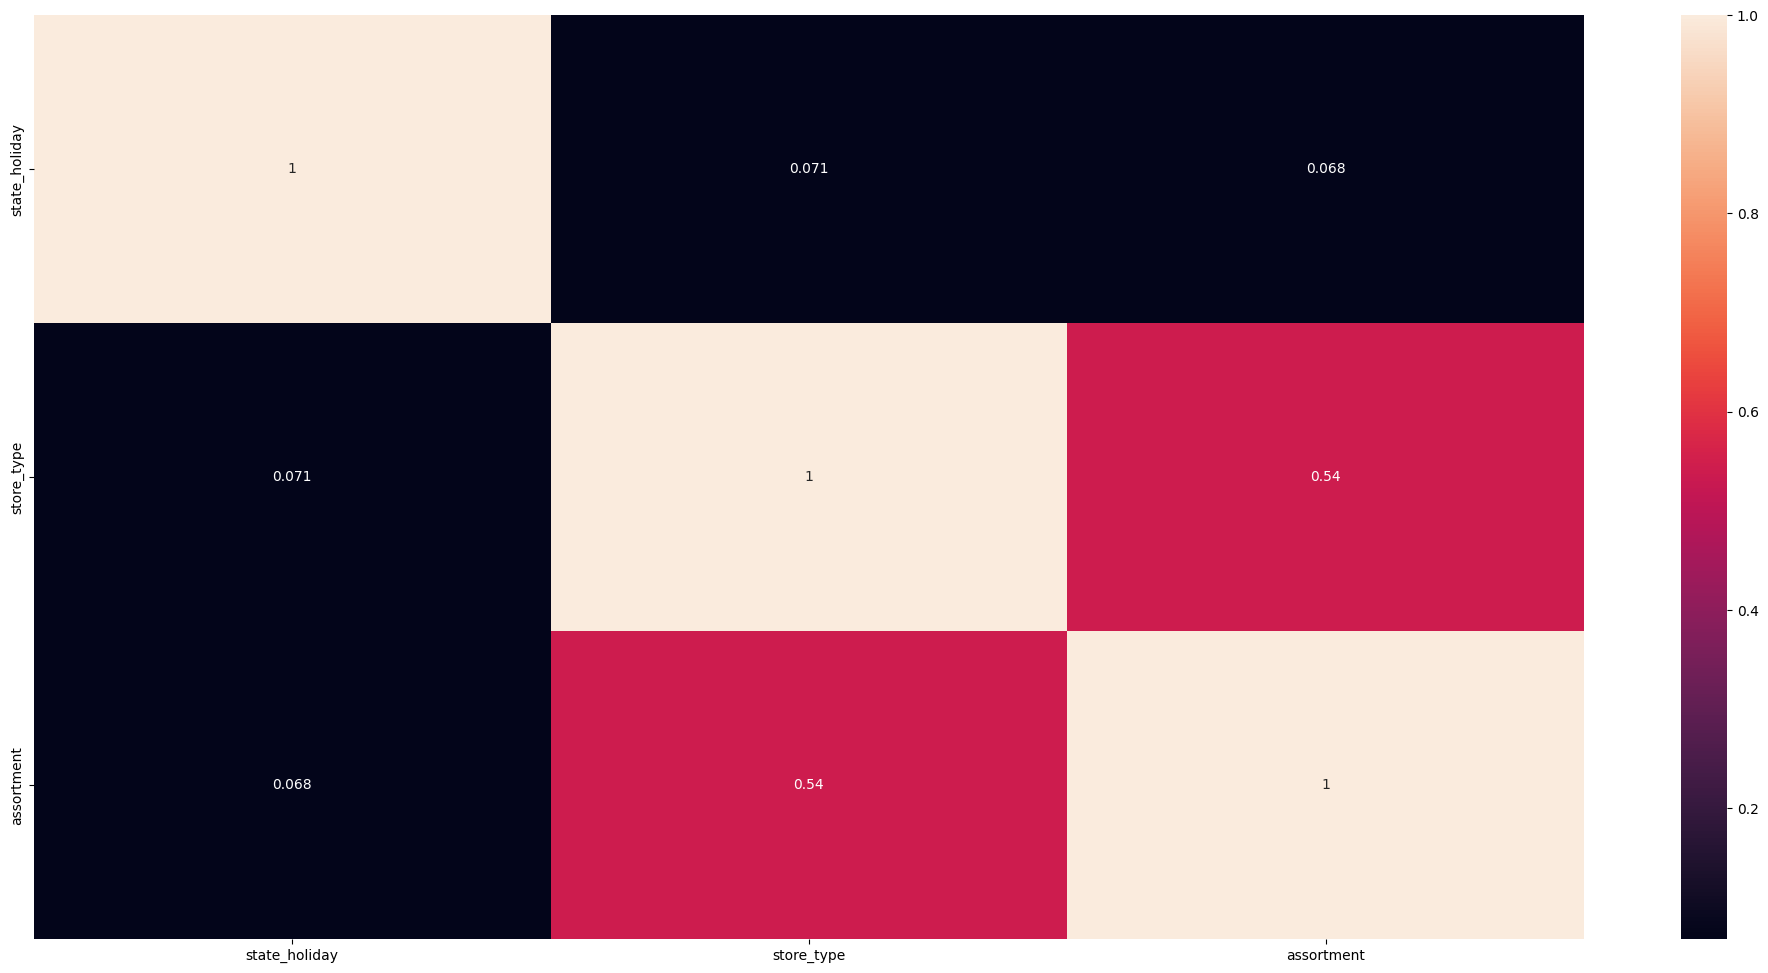

In [75]:
# only categorical data
a = df4.select_dtypes( include='object' )

# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9]  })
d = d.set_index( d.columns )

sns.heatmap( d, annot=True )

# 5.0. Data Preparation 

In [133]:
df5 = df4.copy()

In [134]:
a = df5.select_dtypes(include=['int64', 'float64'])
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0


## 5.1. Rescaling

<Axes: ylabel='year'>

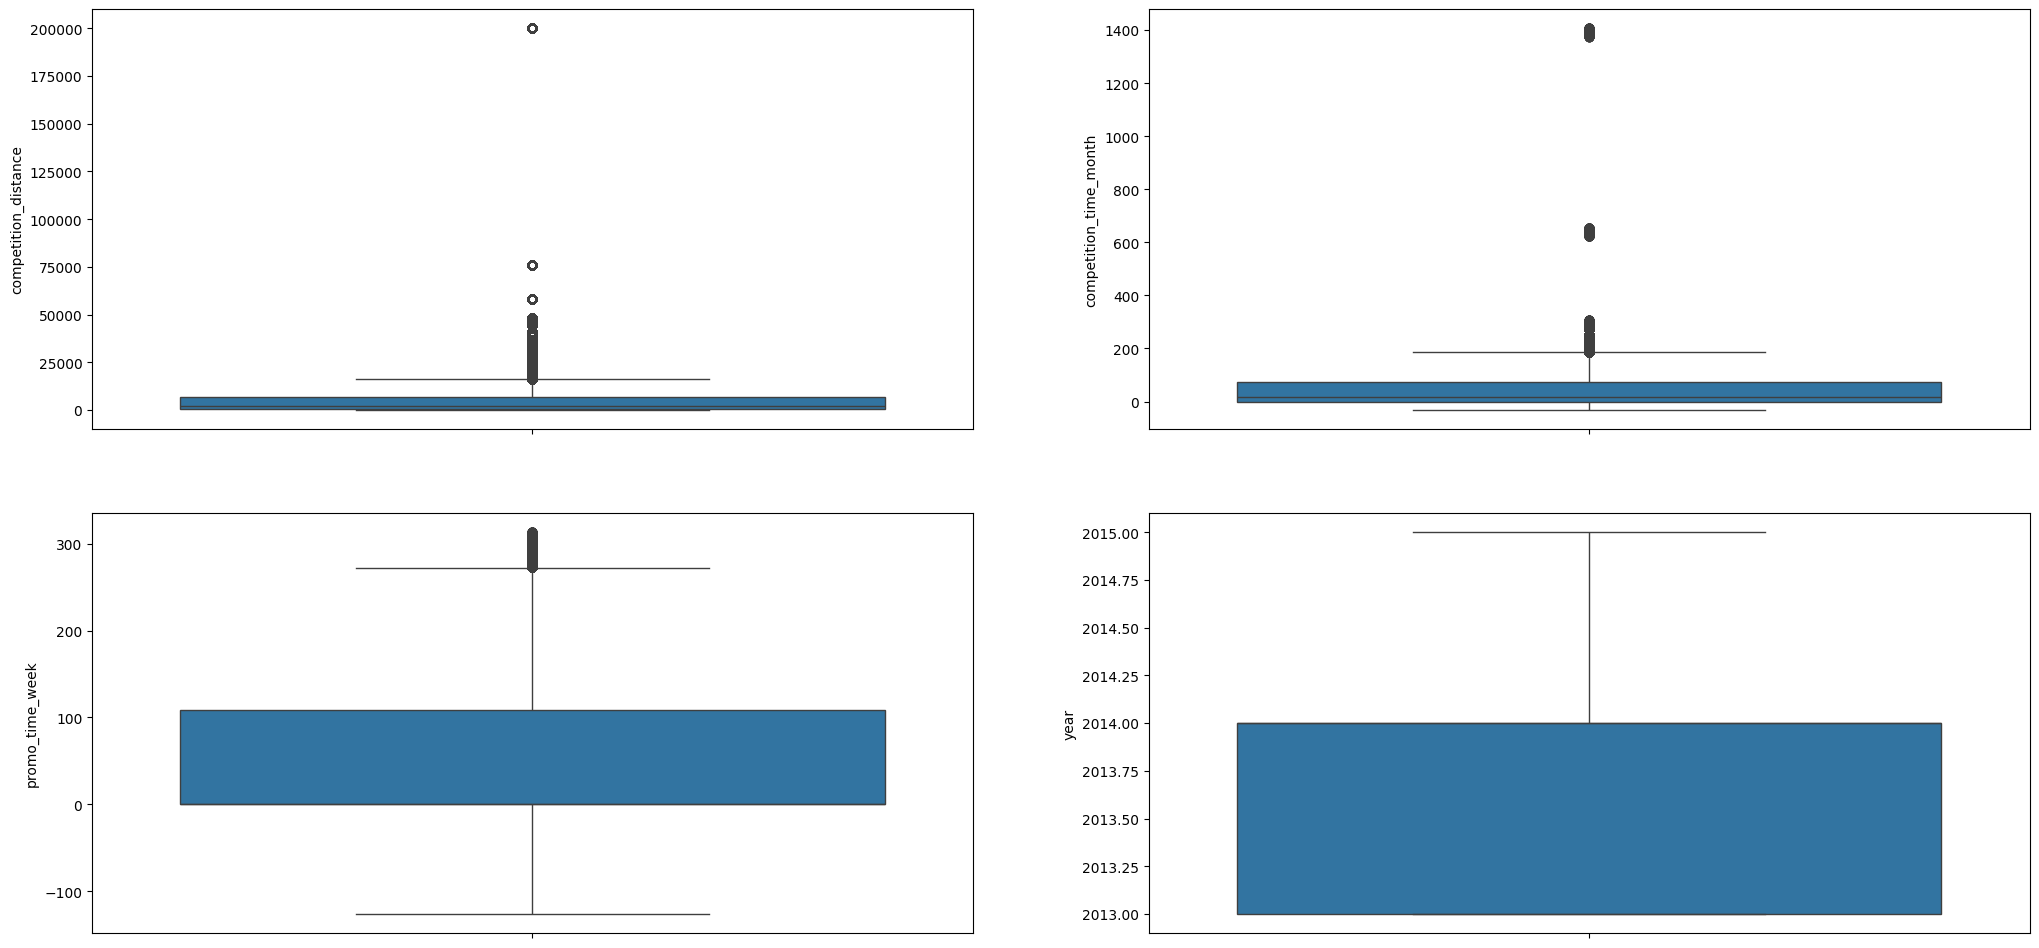

In [135]:
plt.subplot(2,2,1)
sns.boxplot(df5['competition_distance'])
plt.subplot(2,2,2)
sns.boxplot(df5['competition_time_month'])
plt.subplot(2,2,3)
sns.boxplot(df5['promo_time_week'])
plt.subplot(2,2,4)
sns.boxplot(df5['year'])


In [136]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump( rs, open( 'parameter/competition_distance_scaler.pkl', 'wb') )

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
pickle.dump( rs, open( 'parameter/competition_time_month_scaler.pkl', 'wb') )

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
pickle.dump( rs, open( 'parameter/promo_time_week_scaler.pkl', 'wb') )

# year
df5['year'] = mms.fit_transform( df5[['year']].values )
pickle.dump( mms, open( 'parameter/year_scaler.pkl', 'wb') )

## 5.2. Transformation

### 5.2.1. Encoding

In [137]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
pickle.dump( le, open( 'parameter/store_type_scaler.pkl', 'wb') )

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 5.2.2. Response Variable Transformation

In [138]:
# df5['sales'] = np.log1p( df5['sales'] )

In [139]:
# sns.displot(df5['sales'])

### 5.2.3. Nature Transformation

In [140]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day 
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

# 6.0 Feature Selection

In [142]:
df6 = df5.copy()

## 6.1. Training Test Split

In [143]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week' ]
df6 = df6.drop( cols_drop, axis=1 )

In [144]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2. Correlation-Based Feature Selector

In [145]:
correlation_matrix = df6.corr()
feature_scores = abs(correlation_matrix['sales'])
selected_features = feature_scores.nlargest(22).index

In [146]:
selected_features = selected_features.drop(['sales', 'date'])

In [147]:
selected_features

Index(['promo', 'day_of_week_sin', 'promo2', 'assortment', 'promo2_since_week',
       'day_cos', 'promo2_since_year', 'is_promo', 'promo_time_week',
       'day_sin', 'competition_distance', 'school_holiday', 'day_of_week_cos',
       'year', 'state_holiday_regular_day', 'week_of_year_cos', 'month_cos',
       'store_type', 'state_holiday_public_holiday',
       'competition_open_since_year'],
      dtype='object')

# 7.0. Machine Learning Modelling

In [148]:
x_train = X_train[selected_features]
x_test = X_test[selected_features]

## 7.1. Average Model

In [149]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store_type', 'sales']].groupby( 'store_type' ).mean().reset_index().rename( columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store_type' )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', (y_test), (yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,2224.518778,0.380121,2999.804891


## 7.2. Linear Regression Model

In [150]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', (y_test),(yhat_lr) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1935.312315,0.326582,2662.864642


### 7.2.1. Linear Regression Model - Cross Validation

In [151]:
lr_result_cv = cross_validation(x_train, y_train, 5, 'Linear Regression', lr)
lr_result_cv

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,2008.941127,0.338651,2771.048668


## 7.3. Linear Regression Regularized Model - Lasso

In [154]:
# model
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', y_test, yhat_lrr)
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1935.280278,0.326569,2662.851875


### 7.3.1.  Lasso - Cross Validation

In [155]:
lrr_result_cv = cross_validation( x_train, y_train, 5, 'Lasso', lrr)
lrr_result_cv

,Model Name,MAE,MAPE,RMSE
0,Lasso,2008.929232,0.338649,2771.012386


## 7.4. Random Forest Regressor

In [156]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', y_test, yhat_rf)
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,752.781763,0.115382,1120.001985


### 7.4.1.  Random Forest Regressor - Cross Validation

In [157]:
rf_result_cv = cross_validation( x_train, y_train, 5, 'Random Forest Regressor', rf)
rf_result_cv

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,627.266804,0.095625,1033.307289


## 7.5. XGBoost Regressor

In [158]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100, 
                              eta=0.1, 
                              max_depth=10, 
                              subsample=0.7,
                              colsample_bytree=0.9 ).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', y_test, yhat_xgb)
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,982.09169,0.161428,1377.089734


### 7.5.1. XGBoost Regressor - Cross Validation

In [159]:
xgb_result_cv = cross_validation( x_train, y_train, 5, 'XGBoost Regressor', model_xgb)
xgb_result_cv

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,849.920354,0.139508,1245.911061


## 7.6. Compare Model's Performance

### 7.6.1. Single Performance

In [160]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,752.781763,0.115382,1120.001985
0,XGBoost Regressor,982.091690,0.161428,1377.089734
0,Linear Regression - Lasso,1935.280278,0.326569,2662.851875
0,Linear Regression,1935.312315,0.326582,2662.864642
0,Average Model,2224.518778,0.380121,2999.804891


### 7.6.2. Real Performance - Cross Validation

In [161]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result_cv

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,2008.941127,0.338651,2771.048668
0,Lasso,2008.929232,0.338649,2771.012386
0,Random Forest Regressor,627.266804,0.095625,1033.307289
0,XGBoost Regressor,849.920354,0.139508,1245.911061


# 8.0. Hyperparameter Fine Turing

## 8.1. Random Search

In [172]:
param = [50, 100, 150, 200]

In [173]:
final_result = pd.DataFrame()

for i in param:
    print( 'n_estimator:', i )
   
    # model
    model_rf = RandomForestRegressor( n_estimators=i,
                                     n_jobs=-1,
                                     random_state=42 )

    # performance
    result = cross_validation( x_train, y_train, 5, 'Random Forest', model_rf)

    final_result = pd.concat( [final_result, result] )
       
final_result


n_estimator: 50
n_estimator: 100
n_estimator: 150
n_estimator: 200


,Model Name,MAE,MAPE,RMSE
0,Random Forest,631.813959,0.096278,1038.747012
0,Random Forest,628.393347,0.095640,1033.367215
0,Random Forest,626.014387,0.095233,1033.398581
0,Random Forest,624.954296,0.095180,1030.661671


## 8.2. Final Model

In [176]:
# model
model_rf = RandomForestRegressor( n_estimators= 50,
                                n_jobs=-1,
                                random_state=42 ).fit( x_train, y_train )

# prediction
yhat_rf = model_rf.predict( x_test )

# performance
rf_result_tuned = ml_error( 'Random Forest', y_test, yhat_rf)
rf_result_tuned

,Model Name,MAE,MAPE,RMSE
0,Random Forest,755.834369,0.115787,1124.713656


In [ ]:
# Save Trained Model
pickle.dump( model_rf, open( '/Users/jooji/datascience/repository/Rossmann-Sales-Prediction/notebook/parameter/model_rossmann.pkl', 'wb' ) )

# 9.0. Interpretation of Errors

In [178]:
df9 = X_test

# rescale
df9['sales'] = df9['sales']
df9['predictions'] = yhat_rf

## 9.1. Business Performance

In [179]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [180]:
df92.sort_values( 'MAPE', ascending=False ).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
593,594,391173.747206,384880.240525,397467.253888,6293.506681,1.592127
472,473,234043.724714,230997.461884,237089.987544,3046.262830,0.961027
291,292,110346.060000,106728.355789,113963.764211,3617.704211,0.641101
908,909,263770.500000,256472.057391,271068.942609,7298.442609,0.529070
549,550,260989.140000,259134.109189,262844.170811,1855.030811,0.372255


<Axes: xlabel='store', ylabel='MAPE'>

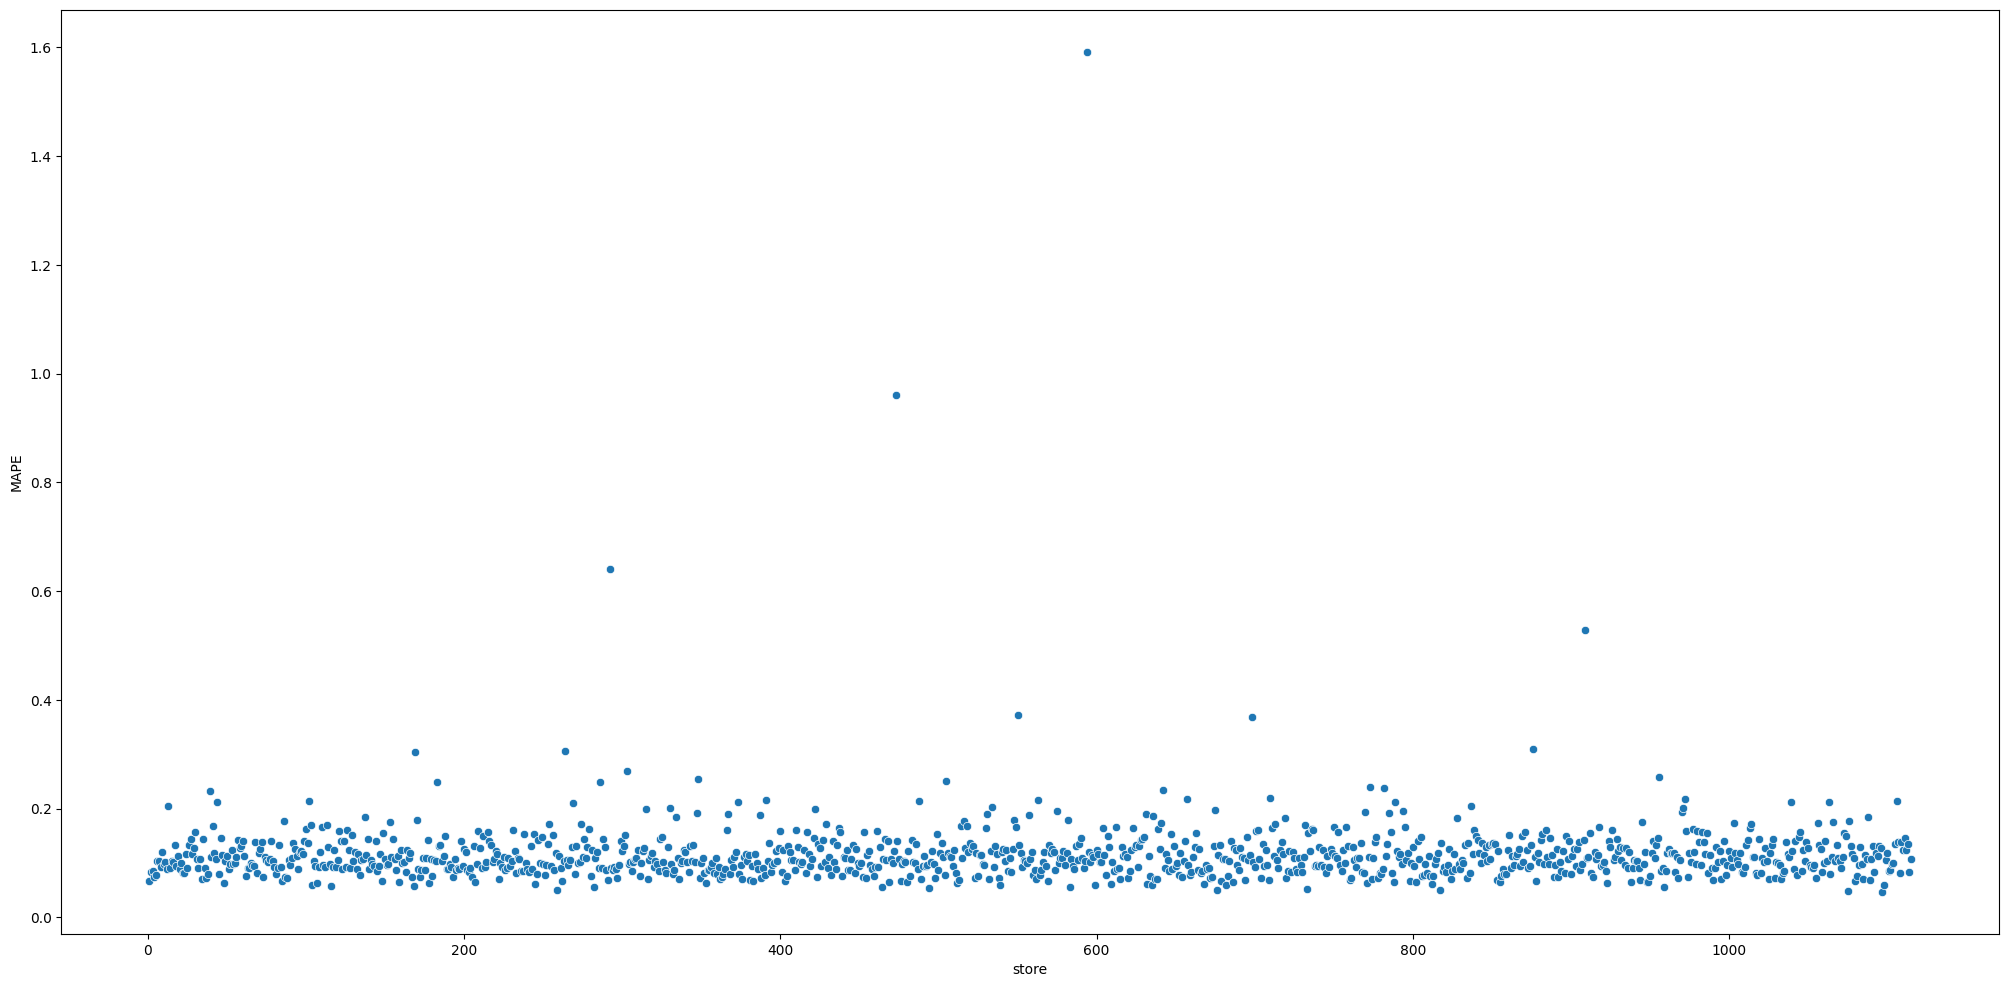

In [181]:
sns.scatterplot( x='store', y='MAPE', data=df92 )

## 9.2. Total Performance

In [182]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} )
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format )
df93

,Scenario,Values
0,predictions,"R$297,955,261.99"
1,worst_scenario,"R$297,108,083.32"
2,best_scenario,"R$298,802,440.67"


## 9.3. Machine Learning Performance

In [189]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

<Axes: xlabel='predictions', ylabel='error'>

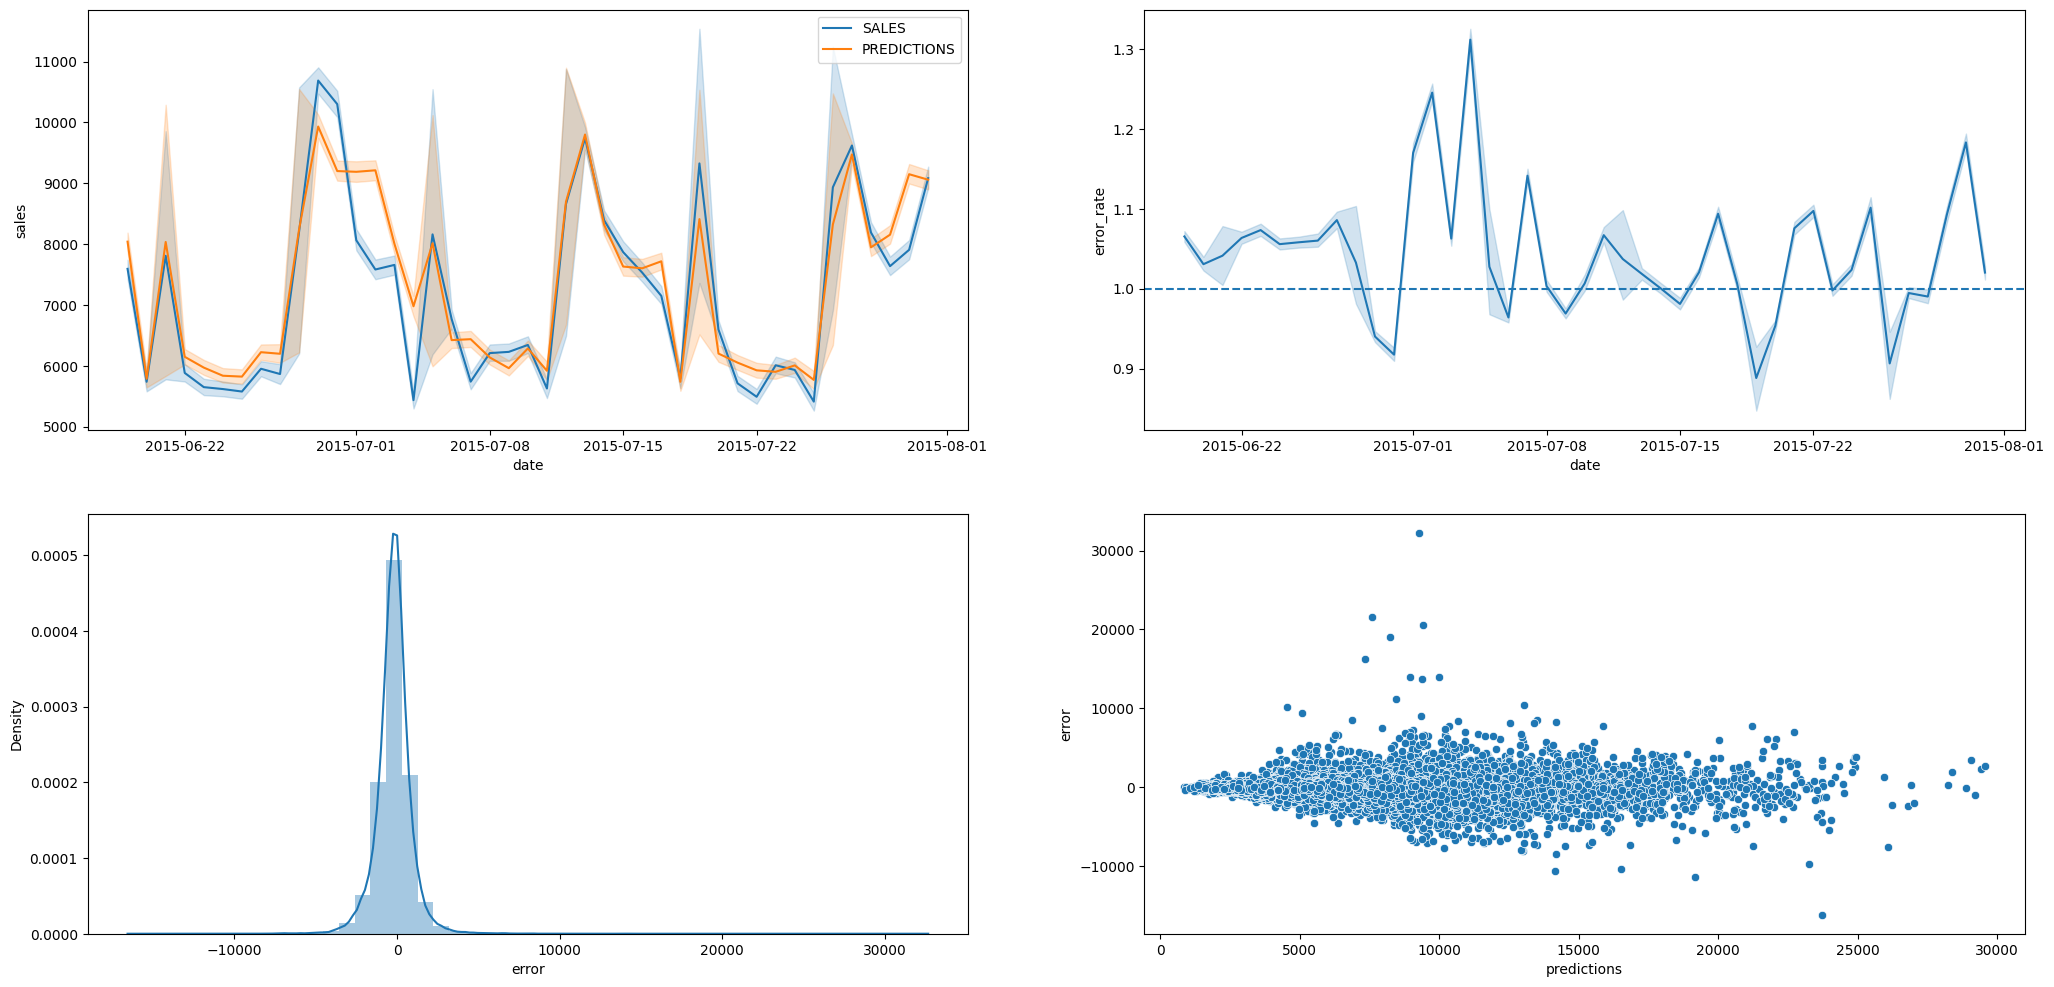

In [190]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot(x='predictions', y='error', data=df9)
